# Visual Q&A
## Project for the Deep Learning course 2021/2022
### Federica Cocci (1802435), Michela Proietti (1739846), Sofia Santilli (1813509)

This project consists in the development of architectures that address the visual question answering (VQA) task, which is a semantic task that aims at answering questions based on an image.

In particular, starting from previous works, we have developed two trivial baselines (random and prior yes), a non trivial baseline, and a final more complex architecture, which can be considered SOTA for the task, since it is the best-ranked model in PapersWithCode leaderboard.

In [ ]:
# We import the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Who is running the code
user = 'federica'

# We define the path to the project's directory for each user
if user == 'michela':
  path_main_directory = '/content/drive/MyDrive/DL/Project'
elif user == 'sofia':
  path_main_directory = '/content/drive/MyDrive/DEEP_LEARNING/Deep_project'
else:
  path_main_directory = '/content/drive/MyDrive/DL_PROJECT_local'

# Whether we need to download the datasets
DOWNLOAD_DATA = False  

# Approach to train or evaluate
APPROACH = "approach_2"   # 'random', 'prior_yes', 'approach_1', 'approach_2'

## Experimental setup

### Libraries imports

In [ ]:
!pip install pytorch-lightning

if APPROACH == 'approach_2':
  !pip install transformers

  # Detectron2
  !python -m pip install pyyaml==5.1
  # Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
  # so we install from source instead. This takes a few minutes.
  #!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
  !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 15.7 MB/s 
     |████████████████████████████████| 140 kB 76.1 MB/s 
     |████████████████████████████████| 419 kB 59.2 MB/s 
     |████████████████████████████████| 596 kB 35.2 MB/s 
     |████████████████████████████████| 1.1 MB 62.5 MB/s 
     |████████████████████████████████| 271 kB 78.0 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 73.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.3 MB/s 
     |████████████████████████████████| 6.6 MB 54.6 MB/s 
     |████████████████████████████████| 101 kB 14.9 MB/s 
Looking in indexe

In [ ]:
import os
import re
import cv2
import json
import torch
import pickle
import random
import operator
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import randint, seed
from sklearn import preprocessing
import pytorch_lightning as pl
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split # random_split(dataset, lengths) randomly split a dataset into non-overlapping new datasets of given lengths
from typing import Callable, Optional, List, Union, Dict, Tuple

# CNN + LSTM
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.tokenize import word_tokenize

from torch.nn import Module, Conv2d, Linear, Flatten, MaxPool2d, CrossEntropyLoss, Dropout, Tanh, ReLU, Sequential, Softmax, GRU
from torch.optim import Adam, SGD

# Generative vqa using crossmodal
import PIL
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, display

# Compute image features
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms

# Reading files directly from zip
import io
#from PIL import Image
from zipfile import ZipFile

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

if APPROACH == 'approach_2':
  from transformers import LxmertForQuestionAnswering, LxmertTokenizer, LxmertConfig

  import detectron2
  # import some common detectron2 utilities
  from detectron2.engine import DefaultPredictor
  from detectron2.config import get_cfg
  from detectron2.utils.visualizer import Visualizer
  from detectron2.data import MetadataCatalog
  from detectron2 import model_zoo
  from detectron2.modeling.postprocessing import detector_postprocess
  from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image
  from detectron2.modeling.box_regression import Box2BoxTransform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Global variables and hyperparameters

We define some global variables that are used to decide whether or not to perform data preprocessing, what approach to train and test, and all the training hyperparameters.

In [ ]:
DATASET_ANALYSIS = False
BUILD_IMG_IDS_DICT = False
BUILD_VOCAB_LAYER_DICTS = False
CREATE_PREPROCESSED_DATASETS = False

RATIO = 10 # Ratio of dataset to consider

# Training hyperparameters
PRETRAINED = False
BATCH_SIZE = 2

# APPROACH 1 (CNN+LSTM)
K = 1000 # We perform the classification over the K most frequent answers
DOWNLOAD_GLOVE = False
CREATE_GLOVE_DICT = False
GLOVE_DIM = 300
USE_PREFERENCES = False # Whether to use or not the preferences while computing the loss

# APPROACH 2 (GENERATIVE LXMERT)
# FasterRCNN parameters
MIN_BOXES = 1
MAX_BOXES = 10

# LXMERT parameters
MAX_SEQ_LEN = 10   # tokenizer
MAX_ANSW_LEN = 5  # usata per paddare la risposta

### Paths definition

In [ ]:
# This function checks whether a folder already exists. If not, it is created.

def check_and_create_dir(path):
  if not os.path.isdir(path):
    os.mkdir(path)

In [ ]:
## Path to the dataset
data_path = path_main_directory + '/data/'
check_and_create_dir(data_path)

## Paths for the dictionaries mapping image ids to image filenames
dicts_dir_path = path_main_directory + '/image_ids_dictionaries/'
check_and_create_dir(dicts_dir_path)

train_coco_dict_path = dicts_dir_path + 'train_coco.json'
val_coco_dict_path = dicts_dir_path + 'val_coco.json'
train_abs_dict_path = dicts_dir_path + 'train_abs.json'
val_abs_dict_path = dicts_dir_path + 'val_abs.json'

## Paths to the preprocessed datasets
processed_data_path = path_main_directory + '/processed_data/'
check_and_create_dir(processed_data_path)

if (APPROACH == "approach_1"):
  processed_train_path = processed_data_path + f'train_processed_approach1_{str(RATIO)}.csv'
  processed_val_path = processed_data_path + f'val_processed_approach1_{str(RATIO)}.csv'
elif (APPROACH == "approach_2"):
  processed_train_path = processed_data_path + f'train_processed_approach2_{str(RATIO)}.csv'
  processed_val_path = processed_data_path + f'val_processed_approach2_{str(RATIO)}.csv'

## Results paths
results_dir = path_main_directory + '/results/'
check_and_create_dir(results_dir)
# - RANDOM
random_baseline_path = results_dir + 'random_baseline.json'
# - PRIOR YES 
prior_yes_path = results_dir + 'prior_yes.json'
# - APPROACH 1-2
results_path = results_dir + f'{APPROACH}_glove{GLOVE_DIM}d_pref{USE_PREFERENCES}.json'

## Paths for model's checkpoints
path_trainer = path_main_directory + '/checkpoints/'
check_and_create_dir(path_trainer)

path_models = path_main_directory + '/models/'
check_and_create_dir(path_models)

# - APPROACH 1-2
model_path = path_models + f'{APPROACH}_glove{GLOVE_DIM}d_pref{USE_PREFERENCES}.pth'


## APPROACH 1
word_emb_path = path_main_directory + '/word_embeddings/'
check_and_create_dir(word_emb_path)

glove_dict_dir = path_main_directory + '/dictionaries/'
check_and_create_dir(glove_dict_dir)
glove_dict_path = glove_dict_dir + f'glove{GLOVE_DIM}_dictionary.npy'

## APPROACH 2
# Paths for dictionaries for vocabulary layer (with all words from questions and answers in the training dataset)
path_vocab_dir = path_main_directory + '/dictionaries/'
check_and_create_dir(path_vocab_dir)

path_vocab_itos = path_vocab_dir + 'words_itos.json'
path_vocab_stoi = path_vocab_dir + 'words_stoi.json'
path_vocab_words = path_vocab_dir + 'vocab_words.json'



### Datasets downloading

The dataset that is used in this project is [Visual Q&A v2.0](https://visualqa.org/download.html). Visual Question Answering (VQA) v2.0 is a dataset containing open-ended questions about images. These questions require an understanding of vision, language and commonsense knowledge
to answer. It is the second version of the VQA dataset. It consists of:
1. Images from COCO and Abstract Scenes
2. At least 3 questions (5.4 questions on average) per image
3. 10 ground truth answers per question
4. 3 plausible (but likely incorrect) answers per question

Here, we are downloading the zip files of COCO and Abstract Scenes and saving them on drive. The downloaded zips are 12. We have the images zip, questions zip and annotations zip for:

*   training with COCO
*   validation with COCO
*   training with Abstract Scenes
*   validation with Abstract Scenes


In [ ]:
if DOWNLOAD_DATA:
  if user == 'michela':
    # Getting real images + questions + annotations
    # Training set
    !wget -P /content/drive/MyDrive/DL/Project/data http://images.cocodataset.org/zips/train2014.zip
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
    # Validation set
    !wget -P /content/drive/MyDrive/DL/Project/data http://images.cocodataset.org/zips/val2014.zip
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip

    # Getting abstract images + questions + annotations
    # Training set
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_train2015.zip
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Train_abstract_v002.zip
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Train_abstract_v002.zip
    # Validation set
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_val2015.zip
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Val_abstract_v002.zip
    !wget -P /content/drive/MyDrive/DL/Project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Val_abstract_v002.zip
  elif user == 'sofia':
    # Getting real images + questions + annotations
    # Training set
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data http://images.cocodataset.org/zips/train2014.zip
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
    # Validation set
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data http://images.cocodataset.org/zips/val2014.zip
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip

    # Getting abstract images + questions + annotations
    # Training set
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_train2015.zip
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Train_abstract_v002.zip
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Train_abstract_v002.zip
    # Validation set
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_val2015.zip
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Val_abstract_v002.zip
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Val_abstract_v002.zip
  else:
    # Getting real images + questions + annotations
    # Training set
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data http://images.cocodataset.org/zips/train2014.zip
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
    # Validation set
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data http://images.cocodataset.org/zips/val2014.zip
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip

    # Getting abstract images + questions + annotations
    # Training set
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_train2015.zip
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Train_abstract_v002.zip
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Train_abstract_v002.zip
    # Validation set
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_val2015.zip
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Val_abstract_v002.zip
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/data https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Val_abstract_v002.zip

### Useful functions

Now, we define some useful functions that are used throughout the code many times for all the different approaches.

In [ ]:
# This function is used to extract questions and annotations from the respective
# archives. It gets as input an archive and the type of data that we need to extract.

def get_items_from_archive(archive, item_type='questions'):
  with archive.open(archive.namelist()[0], 'r') as f:
    data = json.load(f)   # data is a dictionary with keys: 
                          # (questions) info, task_type, data_type, license, data_subtype, questions 
                          # (annotations) info, license, data_subtype, annotations, data_type
    items = data[item_type]

  return items

In [ ]:
# These functions are used to save/load a dictionary to/from a json file.
def save_dict_to_json(dictionary, save_path):
  with open(save_path, 'w') as fp:
    json.dump(dictionary, fp)

def load_dict_from_json(save_path):
  with open(save_path, 'r') as fp:
    data = json.load(fp)
  return data

In [ ]:
# This function extracts the images from the corresponding zip file, batch by batch.
# In fact, we do not have enough resources to extract the whole image datasets.
def retrieve_batch_images(image_filenames, train_flag):

    if APPROACH == 'approach_1':
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

      transform = transforms.Compose([
                  transforms.Resize((224,224)),
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),
                  normalize])
    
    if train_flag:
      archives = train_archives
    else:
      archives = val_archives

    # Retrieve image from archive
    images = []
    for image_filename in image_filenames:
      if 'COCO' in image_filename:
        img = archives[0].read(image_filename)
      else:
        img = archives[3].read(image_filename)

      if APPROACH == 'approach_1':
        img = PIL.Image.open(io.BytesIO(img))
        img = img.convert('RGB')
        img = transform(img)
      else:
        img = cv2.imdecode(np.frombuffer(img, np.uint8), cv2.COLOR_BGR2RGB)
        if len(img.shape) < 3:
          img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

      images.append(img)      
    
    if APPROACH == 'approach_1':
      images = torch.stack(images)
    
    return images

## Loading datasets

First, we organize the zip files so that we have two lists, one for the training and one for the validation, in which we have: (1) COCO images, (2) COCO questions, (3) COCO annotations, (4) Abstract images, (5)Abstract questions, (6) Abstract annotations, in this order.



In [ ]:
zipfiles = os.listdir(data_path)

# we are listing all the zip files available for training and for validation:

train_zips = [] # Coco images, questions, annotation, Abstract images, questions, annotations
val_zips = []

for i in range(6):
  for file in zipfiles:

    # Coco
    if i == 0 and 'train2014' in file:
      train_zips.append(data_path + file)
    elif i == 0 and 'val2014' in file:
      val_zips.append(data_path + file)
    
    elif i == 1 and 'v2_Questions_Train_mscoco' in file:
      train_zips.append(data_path + file)
    elif i == 1 and 'v2_Questions_Val_mscoco' in file:
      val_zips.append(data_path + file)

    elif i == 2 and 'v2_Annotations_Train_mscoco' in file:
      train_zips.append(data_path + file)
    elif i == 2 and 'v2_Annotations_Val_mscoco' in file:
      val_zips.append(data_path + file)

    # Abstract Scenes
    elif i == 3 and 'scene_img_abstract_v002_train2015' in file:
      train_zips.append(data_path + file)
    elif i == 3 and 'scene_img_abstract_v002_val2015' in file:
      val_zips.append(data_path + file)

    elif i == 4 and 'Questions_Train_abstract_v002' in file:
      train_zips.append(data_path + file)
    elif i == 4 and 'Questions_Val_abstract_v002' in file:
      val_zips.append(data_path + file)

    elif i == 5 and 'Annotations_Train_abstract_v002' in file:
      train_zips.append(data_path + file)
    elif i == 5 and 'Annotations_Val_abstract_v002' in file:
      val_zips.append(data_path + file)

In [ ]:
# The files are opened in reading mode

train_archives = [ZipFile(file, 'r') for file in train_zips]
val_archives = [ZipFile(file, 'r') for file in val_zips]

## Dataset analysis

At this point, we perform a detailed analysis of the dataset in order to have a deep understanding of the data we are going to use.

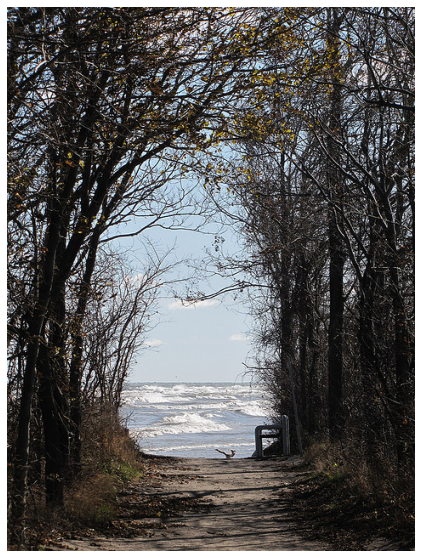

In [ ]:
if DATASET_ANALYSIS:
  # We print an image from COCO
  imgs_archive = train_archives[0]
  files = imgs_archive.namelist()[1:]  # returns a list of file names in Zip archive. Remove first element since contains the folder name
  img = imgs_archive.read(files[0])
  img = PIL.Image.open(io.BytesIO(img))
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  plt.axis('off')

In [ ]:
if DATASET_ANALYSIS:
  # Define a transform to convert the image to tensor
  transform = transforms.ToTensor()
  img_tensor = transform(img)
  print(img_tensor)

tensor([[[0.2392, 0.2000, 0.1412,  ..., 0.1176, 0.2078, 0.1255],
         [0.1529, 0.1843, 0.0431,  ..., 0.1137, 0.0353, 0.0627],
         [0.1490, 0.1529, 0.2863,  ..., 0.1098, 0.7725, 0.5451],
         ...,
         [0.3020, 0.3608, 0.4314,  ..., 0.2588, 0.4275, 0.3647],
         [0.4000, 0.4275, 0.4039,  ..., 0.2000, 0.3373, 0.3294],
         [0.3725, 0.3686, 0.2549,  ..., 0.1922, 0.3647, 0.3059]],

        [[0.2431, 0.1765, 0.1294,  ..., 0.1961, 0.2039, 0.1294],
         [0.2471, 0.2353, 0.0275,  ..., 0.0000, 0.0471, 0.0118],
         [0.1098, 0.1098, 0.2588,  ..., 0.1333, 0.7451, 0.4196],
         ...,
         [0.1804, 0.2510, 0.3412,  ..., 0.2314, 0.4000, 0.3490],
         [0.2902, 0.3333, 0.3333,  ..., 0.1529, 0.2980, 0.2902],
         [0.2863, 0.2902, 0.1961,  ..., 0.1373, 0.3098, 0.2510]],

        [[0.2627, 0.3098, 0.1725,  ..., 0.2314, 0.2235, 0.1451],
         [0.1843, 0.1569, 0.0863,  ..., 0.0863, 0.0196, 0.0902],
         [0.0118, 0.1412, 0.3216,  ..., 0.1176, 0.6353, 0.

{'image_id': 458752, 'question': 'What is this photo taken looking through?', 'question_id': 458752000}
{'question_type': 'what is this', 'multiple_choice_answer': 'net', 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}], 'image_id': 458752, 'answer_type': 'other', 'question_id': 458752000}


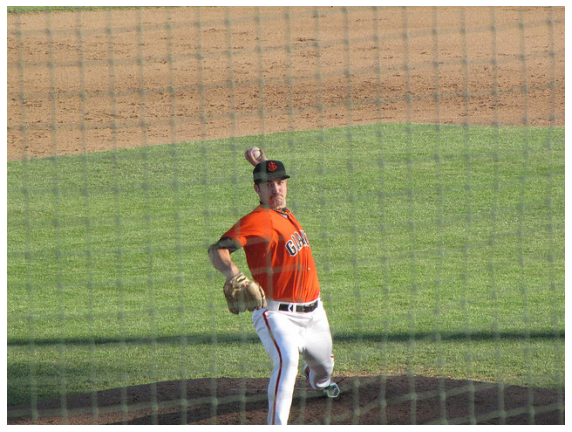

In [ ]:
if DATASET_ANALYSIS:
  # We show an image from COCO and one of the question-annotation pairs related to that image
  qst_archive = train_archives[1]
  ann_archive = train_archives[2]

  questions = get_items_from_archive(qst_archive)
  annotations = get_items_from_archive(ann_archive, 'annotations')

  print(questions[0])
  print(annotations[0])


  for img_name in files:
    if str(questions[0]['image_id']) in img_name:
      img = imgs_archive.read(img_name)
      img = PIL.Image.open(io.BytesIO(img))
      plt.figure(figsize=(10,10))
      plt.imshow(img)
      plt.axis('off')

In [ ]:
if DATASET_ANALYSIS:
  # We check whether the string we have used to separate answers is already
  # present in the dataset.
  for annotation in annotations:
    answers = annotation['answers']

    for answer in answers:
      ans = answer['answer']
      if '/-' in ans:
        print(f'SYMBOL PRESENT IN ANSWER: {ans}')

In [ ]:
if DATASET_ANALYSIS:
  # We check whether we have the same number of questions and annotations
  print(f'Number of questions for COCO images: {len(questions)}')
  print(f'Number of annotations for COCO images: {len(annotations)}\n')

  # We print the number of training and validation images in COCO
  train_imgs = train_archives[0]
  train_files = train_imgs.namelist()[1:]
  print(f'Number of training images in COCO = {len(train_files)}')

  val_imgs = val_archives[0]
  val_files = val_imgs.namelist()[1:]
  print(f'Number of validation images in COCO = {len(val_files)}')

  print(f'Total number of images in COCO = {len(train_files) + len(val_files)}')

Number of questions for COCO images: 443757
Number of annotations for COCO images: 443757

Number of training samples in COCO = 82783
Number of validation samples in COCO = 40504
Total number of samples in COCO = 123287


{'question': 'Who looks happier?', 'image_id': 11779, 'question_id': 117792}
{'question_type': 'who', 'multiple_choice_answer': 'man', 'answers': [{'answer': 'old person', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'man', 'answer_confidence': 'maybe', 'answer_id': 2}, {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'old man', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'grandpa', 'answer_confidence': 'yes', 'answer_id': 10}], 'image_id': 11779, 'answer_type': 'other', 'question_id': 117792}


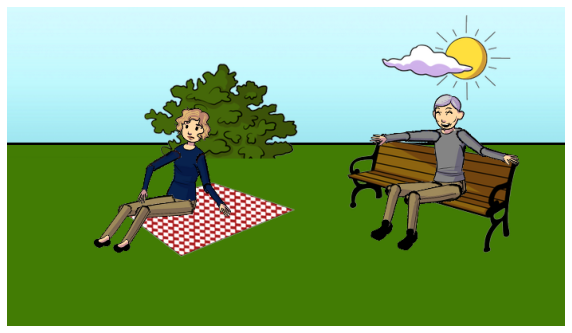

In [ ]:
if DATASET_ANALYSIS:
  # We show an image from Abstract Scenes and one of the question-annotation pairs related to that image
  abs_img_archive = train_archives[3]
  abs_files = abs_img_archive.namelist()

  abs_qst_archive = train_archives[4]
  abs_questions = get_items_from_archive(abs_qst_archive)

  print(abs_questions[0])
  for img_name in abs_files:
    if str(abs_questions[0]['image_id']) in img_name:
      img = abs_img_archive.read(img_name)
      img = PIL.Image.open(io.BytesIO(img))
      plt.figure(figsize=(10,10))
      plt.imshow(img)
      plt.axis('off')

  abs_ann_archive = train_archives[5]
  abs_annotations = get_items_from_archive(abs_ann_archive, 'annotations')

  print(abs_annotations[0])

In [ ]:
if DATASET_ANALYSIS:
  for annotation in abs_annotations:
    answers = annotation['answers']

    for answer in answers:
      ans = answer['answer']
      if '/-' in ans:
        print(f'COMMA PRESENT IN ANSWER: {ans}')

In [ ]:
if DATASET_ANALYSIS:
  # We check whether we have the same number of questions and annotations
  print(f'Number of questions for Abstract images: {len(abs_questions)}')
  print(f'Number of annotations for Abstract images: {len(abs_annotations)}\n')

  # We print the number of training and validation images in Abstract
  train_imgs = train_archives[3]
  train_files = train_imgs.namelist()[1:]
  print(f'Number of training images in Abstract = {len(train_files)}')

  val_imgs = val_archives[3]
  val_files = val_imgs.namelist()[1:]
  print(f'Number of validation images in Abstract = {len(val_files)}')

  print(f'Total number of images in Abstract = {len(train_files) + len(val_files)}')

Number of questions for Abstract images: 60000
Number of annotations for Abstract images: 60000

Number of training images in Abstract = 19999
Number of validation images in Abstract = 9999
Total number of images in Abstract = 29998


It is interesting to understand if the same questions is present multiple times in reference to different images, or if the same image is used to ask different questions, for both the train and validation datasets.

In [ ]:
if DATASET_ANALYSIS:
  # Checking whether the question ids are unique across the two datasets
  questions_coco = get_items_from_archive(train_archives[1])
  questions_abs = get_items_from_archive(train_archives[4])

  coco_qst_ids = [question_coco['question_id'] for question_coco in questions_coco]
  abs_qst_ids = [question_abs['question_id'] for question_abs in questions_abs]

  n = 0
  for qst_id in tqdm(abs_qst_ids):
    if qst_id in coco_qst_ids:
      n += 1

  if n > 0:
    print(f'\nThere are {n} non-unique question ids!')
  else:
    print('The question ids are unique across the datasets')

100%|██████████| 60000/60000 [06:42<00:00, 149.19it/s]


There are 93 non-unique question ids!


The non-uniqueness of the question ids is not a problem because we will consider the couples image id-question id to identify the prediction obtained for a given sample.

In [ ]:
if DATASET_ANALYSIS:
  # Checking whether the image ids are unique across the two datasets
  questions_coco = get_items_from_archive(train_archives[1])
  questions_abs = get_items_from_archive(train_archives[4])

  coco_img_ids = [question_coco['image_id'] for question_coco in questions_coco]
  abs_img_ids = [question_abs['image_id'] for question_abs in questions_abs]

  n = 0
  for img_id in tqdm(abs_img_ids):
    if img_id in coco_img_ids:
      n += 1

  if n > 0:
    print(f'\nThere are {n} non-unique image ids!')
  else:
    print('\nThe image ids are unique across the datasets')

100%|██████████| 60000/60000 [05:47<00:00, 172.83it/s]


There are 8427 non-unique image ids!


Since there aren't unique image ids between COCO and Abstract datasets, we are going to use image filenames instead of image ids.

In [ ]:
if DATASET_ANALYSIS:
  questions_coco = get_items_from_archive(val_archives[1])
  questions_abs = get_items_from_archive(val_archives[4])

  coco_qst_ids = [question_coco['question_id'] for question_coco in questions_coco]
  abs_qst_ids = [question_abs['question_id'] for question_abs in questions_abs]

  n = 0
  for qst_id in tqdm(abs_qst_ids):
    if qst_id in coco_qst_ids:
      n += 1

  if n > 0:
    print(f'\nThere are {n} non-unique question ids!')
  else:
    print('The question ids are unique across the datasets')

100%|██████████| 30000/30000 [01:39<00:00, 300.46it/s]


There are 21 non-unique question ids!


In [ ]:
if DATASET_ANALYSIS:
  questions_coco = get_items_from_archive(val_archives[1])
  questions_abs = get_items_from_archive(val_archives[4])

  coco_img_ids = [question_coco['image_id'] for question_coco in questions_coco]
  abs_img_ids = [question_abs['image_id'] for question_abs in questions_abs]

  n = 0
  for img_id in tqdm(abs_img_ids):
    if img_id in coco_img_ids:
      n += 1

  if n > 0:
    print(f'\nThere are {n} non-unique image ids!')
  else:
    print('The image ids are unique across the datasets')

100%|██████████| 30000/30000 [01:39<00:00, 302.59it/s]


There are 2166 non-unique image ids!


# samples per answer type

other:  0.49
yes/no:  0.38
number:  0.13



# samples per question type

what is this:  0.01
what:  0.07
what color is the:  0.06
is this:  0.03
what is the person:  0.0
what is in the:  0.01
is the:  0.08
is there:  0.01
what is the:  0.05
is:  0.01
is the man:  0.01
none of the above:  0.04
does the:  0.02
are the:  0.02
was:  0.0
how many:  0.1
what color is:  0.01
what is the man:  0.01
what is on the:  0.01
what is:  0.03
how many people are in:  0.0
is there a:  0.02
is it:  0.02
is the person:  0.0
what does the:  0.01
is this a:  0.03
how:  0.01
are there:  0.01
has:  0.0
could:  0.0
where is the:  0.02
are:  0.01
are they:  0.01
are these:  0.01
why is the:  0.0
how many people are:  0.01
what color are the:  0.01
what type of:  0.02
where are the:  0.01
what kind of:  0.02
which:  0.01
do:  0.01
what is the name:  0.0
is this an:  0.0
what is the color of the:  0.0
what color:  0.01
what sport is:  0.0
what are:  0.01
what brand:  0.0
what time:  0.

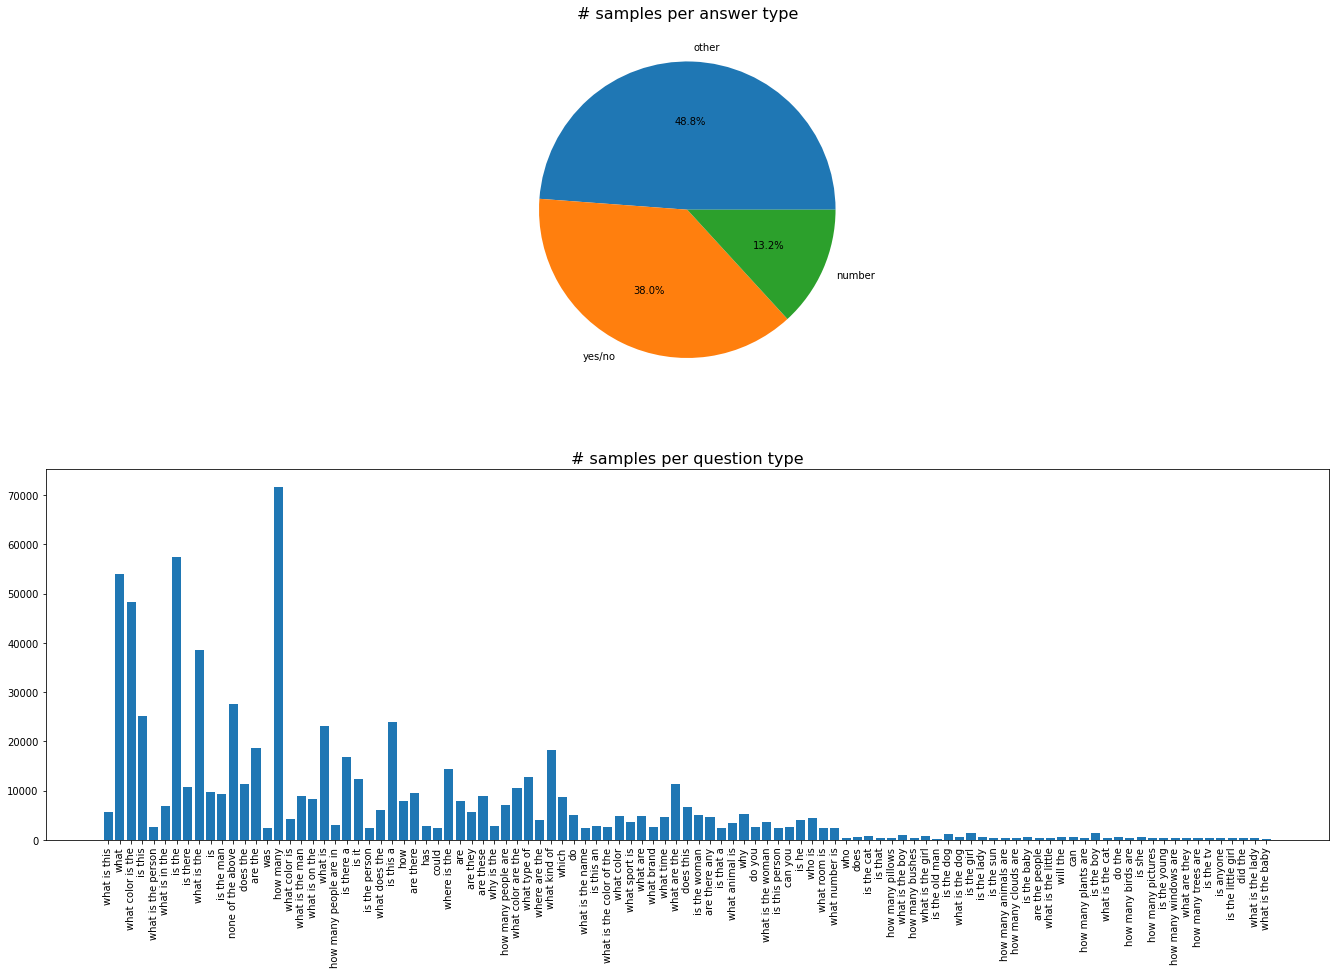

In [ ]:
if DATASET_ANALYSIS:
  # We compute the number of samples per answer type and per question type
  def get_num_ans_per_type(annotations, ans_dict, ques_dict):
    for annotation in annotations:
      ans_type = annotation['answer_type']
      ques_type = annotation['question_type']
      if ans_type in ans_dict.keys():
        ans_dict[ans_type] += 1
      else:
        ans_dict[ans_type] = 1

      if ques_type in ques_dict.keys():
        ques_dict[ques_type] += 1
      else:
        ques_dict[ques_type] = 1
    
    return ans_dict, ques_dict

  ans_type_freq, ques_type_freq = {}, {}
  ans_type_freq, ques_type_freq = get_num_ans_per_type(get_items_from_archive(train_archives[2], 'annotations'), ans_type_freq, ques_type_freq)
  ans_type_freq, ques_type_freq = get_num_ans_per_type(get_items_from_archive(train_archives[5], 'annotations'), ans_type_freq, ques_type_freq)
  ans_type_freq, ques_type_freq = get_num_ans_per_type(get_items_from_archive(val_archives[2], 'annotations'), ans_type_freq, ques_type_freq)
  ans_type_freq, ques_type_freq = get_num_ans_per_type(get_items_from_archive(val_archives[5], 'annotations'), ans_type_freq, ques_type_freq)


  ans_types = ans_type_freq.keys()
  ans_freqs = ans_type_freq.values()

  ques_types = ques_type_freq.keys()
  ques_freqs = ques_type_freq.values()

  print('# samples per answer type\n')
  for key in ans_type_freq.keys():
    print(key+': ', round(ans_type_freq[key]/sum(ans_freqs),2))

  print('\n\n\n# samples per question type\n')
  for key in ques_type_freq.keys():
    print(key+': ', round(ques_type_freq[key]/sum(ques_freqs),2))

  fig = plt.figure(figsize=(23,15))
  plt.subplot(2,1,1)
  plt.pie(ans_freqs, labels = ans_types, autopct='%.1f%%')
  plt.title('# samples per answer type', fontsize=16)
  plt.subplot(2,1,2)
  plt.bar(range(len(ques_types)), ques_freqs, align='center')
  plt.xticks(range(len(ques_types)), ques_types, rotation='90',fontsize=10)
  plt.title('# samples per question type', fontsize=16)
  plt.show()

## Building image_ids dictionary

Each question in the question archives comes with the image_id of the image it is referred to. Since we do not extract all the images from at once, but we extract them batch by batch, we need to be able to find the image we are looking for using its filename. To this aim, we build a dictionary that maps each image_id to the corresponding filename. We save this dictionary in a json file so that we do not need to compute it every time we run the code.

In [ ]:
# This function builds a dictionary with the image_ids from the question dictionary as keys and the filenames from 
# the images dictionary as values, so that it is easier to retrieve the images while building the dataset.

def build_image_ids_dictionary(img_archive, qst_archive, coco_flag):

  # Get all the images' filenames
  img_files = img_archive.namelist()
  if coco_flag:
    img_files = img_files[1:]
  
  print(f'Number of images in the images archive: {len(img_files)}')
  
  # Get all the questions
  json_file = qst_archive.namelist()[0]
  with qst_archive.open(json_file, 'r') as f:
    data = json.load(f)
    questions = data['questions']  # each question is structured as dictionaries with keys (question, image_id, question_id)
  
  # Initialize the output dictionary with the keys being all the image_ids
  output_dict = {}
  for question in questions:
    output_dict[question['image_id']] = 0

  print(f'The number of image_ids from the questions dataset is {len(output_dict.keys())}, which is equal to the number of images.\n')

  for image_id in tqdm(output_dict.keys()):
    for filename in img_files:
      if str(image_id) in filename:
        output_dict[image_id] = filename
        continue

  return output_dict

In [ ]:
if BUILD_IMG_IDS_DICT:
  # We call the above function for all the datasets
  # COCO
  train_coco_dict = build_image_ids_dictionary(train_archives[0], train_archives[1], True)
  val_coco_dict = build_image_ids_dictionary(val_archives[0], val_archives[1], True)
  # Abstract Scene
  train_abs_dict = build_image_ids_dictionary(train_archives[3], train_archives[4], False)
  val_abs_dict = build_image_ids_dictionary(val_archives[3], val_archives[4], False)

In [ ]:
if BUILD_IMG_IDS_DICT:
  # We save the computed dictionaries in separated json files
  save_dict_to_json(train_coco_dict, train_coco_dict_path)
  save_dict_to_json(val_coco_dict, val_coco_dict_path)
  save_dict_to_json(train_abs_dict, train_abs_dict_path)
  save_dict_to_json(val_abs_dict, val_abs_dict_path)

In [ ]:
# We load the precomputed image_ids dictionaries
train_coco_dict = load_dict_from_json(train_coco_dict_path)
val_coco_dict = load_dict_from_json(val_coco_dict_path)

train_abs_dict = load_dict_from_json(train_abs_dict_path)
val_abs_dict = load_dict_from_json(val_abs_dict_path)

## Text processing

Here we implement a class that performs the text processing as taken from the evaluation code for VQA (see https://github.com/GT-Vision-Lab/VQA). The processing consists in:

*   Making all characters lowercase
*   Removing periods except if it occurs as decimal
*   Converting number words to digits
*   Removing articles (a, an, the)
*   Adding apostrophe if a contraction is missing it (e.g., convert ”dont” to ”don’t”)
*   Replacing all punctuation (except apostrophe and colon) with a space character. We do not remove apostrophe because it can incorrectly change possessives to plural, e.g., “girl’s” to “girls” and colons because they often refer to time, e.g., 2:50 pm. In case of comma, no space is inserted if it occurs between digits, e.g., convert 100,978 to 100978.

In [ ]:
class TextProcessing:
  def __init__(self):
    self.contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                "youll": "you'll", "youre": "you're", "youve": "you've"}

    self.manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5', \
                      'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10'}
    self.articles = ['a', 'an', 'the']
    self.periodStrip = re.compile("(?!<=\d)(\.)(?!\d)")
    self.commaStrip = re.compile("(\d)(\,)(\d)")
    self.punct = [';', r"/", '[', ']', '"', '{', '}', '(', ')', '=', '+', '\\', '_', '-', '>', '<', '@', '`', ',', '?', '!']


  def processPunctuation(self, inText):
    outText = inText
    for p in self.punct:
      if (p + ' ' in inText or ' ' + p in inText) or (re.search(self.commaStrip, inText) != None):
        outText = outText.replace(p, '')
      else:
        outText = outText.replace(p, ' ')
    outText = self.periodStrip.sub("",
                    outText,
                    re.UNICODE)
    return outText

  def processDigitArticle(self, inText):
    outText = []
    tempText = inText.lower().split()
    for word in tempText:
      word = self.manualMap.setdefault(word, word)
      if word not in self.articles:
        outText.append(word)
      else:
        pass
    for wordId, word in enumerate(outText):
      if word in self.contractions:
        outText[wordId] = self.contractions[word]
    outText = ' '.join(outText)
    return outText


## APPROACH 1 - Computing the K most frequent answers

In approach 1, we perform the classification over the K (set to 1000) most frequent answers. Here, we are computing a dictionary with all the possible answers in the training set and the number of times each of them appears. In the validation and test sets, we do not consider any answer that is not among the K most frequent ones. If a question has all answers that are not among these K, the question is not considered. For further details see the implementation of approach 1 below.

In [ ]:
if APPROACH == "approach_1" or APPROACH == 'random':
  frequency_dict = {}

  # We retrieve all the training annotations
  train_coco_anns = get_items_from_archive(train_archives[2], 'annotations')
  train_abs_anns = get_items_from_archive(train_archives[5], 'annotations')

  for annotation in train_coco_anns:
    # Answers to a certain questions
    answers = annotation['answers']
    list_answers = []

    for answer in answers:
      list_answers.append(answer['answer'])

    # If an answer appear multiple times for the same question, we consider it once. 
    list_answers = set(list_answers)

    # We compute the frequency of each answer
    for answer in list_answers:
      if answer in frequency_dict.keys():
        frequency_dict[answer] += 1
      else:
        frequency_dict[answer] = 1

  # We do the same as before, but for the abstract dataset
  for annotation in train_abs_anns:
    answers = annotation['answers']
    list_answers = []

    for answer in answers:
      list_answers.append(answer['answer'])

    list_answers = set(list_answers)

    for answer in list_answers:
      if answer in frequency_dict.keys():
        frequency_dict[answer] += 1
      else:
        frequency_dict[answer] = 1

  print(f'Total number of distinct answers = {len(frequency_dict.keys())}')

  # We sort the frequency dictionary by value in descending order
  frequency_dict = dict(sorted(frequency_dict.items(), key=operator.itemgetter(1),reverse=True))

  # We just take the K most frequent answers
  K_most_frequent_answers = list(frequency_dict.keys())[:K]
  print(f'The {K} most frequent words are: {K_most_frequent_answers}')

## APPROACH 2 - Vocabulary for the vocab-layer

For approach 2, we need to build a dictionary made up of all the different words that appear in the questions and answers in the training dataset. This will be used in the vocabulary layer within the network. 

In [ ]:
# This function preprocesses the questions/answers and splits them into words
def extract_words(txt):
  text_processing = TextProcessing()
  # We remove punctuation marks
  txt = text_processing.processPunctuation(txt)
  # We split the sentence into words
  txt = txt.split()

  return txt

# Adds all words from the dataset's annotations to the given set
def add_ans_words_to_set(vocab_words, data_list):
  for annotation in tqdm(data_list):
    # We take all the answers to a certain question
    answers = annotation['answers']

    for answer in answers:
      # We preprocess each answer and split it into words
      words = extract_words(answer['answer'])

      # We add all the words to vocab_words set (if a word is already present, it is not added)
      for word in words:
        vocab_words.add(word)
    
  return vocab_words

# Adds all words from the dataset's questions to the given set
def add_ques_words_to_set(vocab_words, data_list):
  for question in tqdm(data_list):
    # We preprocess each question and split it into words
    words = extract_words(question["question"])

    # We add all the words to vocab_words set (if a word is already present, it is not added)
    for word in words:
      vocab_words.add(word)
    
  return vocab_words

In [ ]:
if APPROACH == "approach_2" and BUILD_VOCAB_LAYER_DICTS:
  # We retrieve the questions
  train_coco_ques = get_items_from_archive(train_archives[1])
  train_abs_ques = get_items_from_archive(train_archives[4])
  # We retrieve the answers
  train_coco_anns = get_items_from_archive(train_archives[2], 'annotations')
  train_abs_anns = get_items_from_archive(train_archives[5], 'annotations')

  vocab_words = set()  # A set cannot have twice the same element!!!
  
  # We add the UNK, CLS and SEP tokens
  vocab_words.add("[UNK]")
  vocab_words.add("[CLS]")
  vocab_words.add("[SEP]")
  vocab_words.add("[PAD]")

  # We add all words from questions and answers to the set
  vocab_words = add_ans_words_to_set(vocab_words, train_coco_anns)
  print("Number of different words until now: ", len(vocab_words))

  vocab_words = add_ans_words_to_set(vocab_words, train_abs_anns)
  print("Number of different words until now: ", len(vocab_words))

  vocab_words = add_ques_words_to_set(vocab_words, train_coco_ques)
  print("Number of different words until now: ", len(vocab_words))

  vocab_words = add_ques_words_to_set(vocab_words, train_abs_ques)
  print("Total number of different words in the training datasets: ", len(vocab_words))


  vocab_stoi = {s: i for i, s in enumerate(tqdm(vocab_words))}   # dict_word_to_idx
  vocab_itos = {i: s for i, s in enumerate(tqdm(vocab_words))}   # dict_idx_to_word

  # We transform the set to a list
  vocab_words = list(vocab_words)


  print("IDX to WORD", vocab_itos)
  print("WORD to IDX", vocab_stoi)
  print("size IDX to WORD", len(vocab_itos))
  print("size WORD to IDX", len(vocab_stoi))

In [ ]:
if BUILD_VOCAB_LAYER_DICTS:
  save_dict_to_json(vocab_itos, path_vocab_itos)
  save_dict_to_json(vocab_stoi, path_vocab_stoi)
  save_dict_to_json(vocab_words, path_vocab_words)

In [ ]:
if not BUILD_VOCAB_LAYER_DICTS and APPROACH == 'approach_2':
  vocab_itos = load_dict_from_json(path_vocab_itos)
  vocab_itos = {int(k): v for k, v in vocab_itos.items()}

  vocab_stoi = load_dict_from_json(path_vocab_stoi)
  vocab_stoi = {k: int(v) for k, v in vocab_stoi.items()}
  
  vocab_words = load_dict_from_json(path_vocab_words)

## APPROACH 1/2 - Building Glove dictionaries

In [ ]:
if DOWNLOAD_GLOVE:
  if user == 'michela':
    !wget -P /content/drive/MyDrive/DL/Project/word_embeddings https://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q /content/drive/MyDrive/DL/Project/word_embeddings/glove.6B.zip -d /content/drive/MyDrive/DL/Project/word_embeddings/
  elif user == 'sofia':
    !wget -P /content/drive/MyDrive/DEEP_LEARNING/Deep_project/word_embeddings https://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q /content/drive/MyDrive/DEEP_LEARNING/Deep_project/word_embeddings/glove.6B.zip -d /content/drive/MyDrive/DEEP_LEARNING/Deep_project/word_embeddings/
  else:
    !wget -P /content/drive/MyDrive/DL_PROJECT_local/word_embeddings https://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q /content/drive/MyDrive/DL_PROJECT_local/word_embeddings/glove.6B.zip -d /content/drive/MyDrive/DL_PROJECT_local/word_embeddings/

In [ ]:
if CREATE_GLOVE_DICT:
  # Build a dictionary with GloVe word embeddings using all the words that it contains
  glove_dict = dict()
  max_words = 400000

  with open(word_emb_path + f'glove.6B.{GLOVE_DIM}d.txt') as f:
    for i, line in tqdm(enumerate(f), total=max_words):
      if i == max_words:
        break

      word, *vector = line.strip().split(' ')
      vector = torch.tensor([float(n) for n in vector])

      glove_dict[word] = vector

  # Save the dictionary
  np.save(glove_dict_path, glove_dict)

else:
  glove_dict = np.load(glove_dict_path, allow_pickle='TRUE').item()

In [ ]:
# This function is used to index all the words in the GloVe dictionary that we have
# just loaded. It returns the dictionary with the word and its index, that correspond
# to the position of its embedding in the word_vectors list.
# The '[PAD]', '[UNK]', '[CLS]' and '[SEP]' are added.

def build_idx_dictionary(dictionary: dict):
  word_idxs = dict()
  word_vectors = []  # list of all the embeddings

  if APPROACH == 'approach_1':
    add_tokens = 2
  else:
    add_tokens = 4

  for word, vector in dictionary.items():
    word_idxs[word] = len(word_vectors) + add_tokens
    word_vectors.append(vector)
  
  word_vectors = torch.stack(word_vectors)
  wv = word_vectors

  # pad token and unknown token
  pad_emb_tok = torch.zeros((1,word_vectors.shape[1]))   #embedding for '<pad>' token.
  word_idxs['[PAD]'] = 0
  unk_emb_tok = torch.mean(word_vectors,axis=0,keepdims=True)    #embedding for '<unk>' token.
  word_idxs['[UNK]'] = 1

  if APPROACH == 'approach_2':
    CLS_emb_tok = torch.ones(1,word_vectors.shape[1])    #embedding for '<cls>' token.
    word_idxs['[CLS]'] = 2
    SEP_emb_tok = torch.ones(1,word_vectors.shape[1])*2   #embedding for '<sep>' token.
    word_idxs['[SEP]'] = 3
  
  # Insert embeddings for pad, unk, cls and sep tokens at top of word_vectors.
  if APPROACH == 'approach_1':
    word_vectors = torch.vstack((pad_emb_tok,unk_emb_tok,word_vectors))
  else:
    word_vectors = torch.vstack((pad_emb_tok,unk_emb_tok,CLS_emb_tok,SEP_emb_tok,word_vectors))

  print(f'Word vectors shape: {word_vectors.shape}')
  
  word_idxs = defaultdict(lambda: 1, word_idxs)

  return word_idxs, word_vectors, wv

In [ ]:
# We create word_vectors_glove which contains all the word embeddings that are
# present in GloVe. Instead, word_idxs_glove is a dictionary which maps each word
# to the index of its embedding in word_vectors_glove. wv_old is just used to make
# the check in the following cell.

word_idxs_glove, word_vectors_glove, wv_old = build_idx_dictionary(glove_dict)

Word vectors shape: torch.Size([400004, 300])


In [ ]:
# We check that there aren't other embeddings equal to the ones we set for the pad, unk, cls and sep tokens
unk_emb = torch.mean(wv_old,axis=0,keepdims=True)
for i in word_vectors_glove:
  if torch.all(torch.eq(i, torch.zeros(1,word_vectors_glove.shape[1]))):
    print("tok pad")
  if torch.all(torch.eq(i, unk_emb)):
    print("tok unk")
  if torch.all(torch.eq(i, torch.ones(1,word_vectors_glove.shape[1]))):
    print("tok cls")
  if torch.all(torch.eq(i, torch.ones(1,word_vectors_glove.shape[1])*2)):
    print("tok sep")

tok pad
tok unk
tok cls
tok sep


## Create and save preprocessed datasets
In order to not overload the RAM when creating the dataset and starting the training, we perform some data preprocessing and prepare data for the actual creation of the dataset which will be done later. The preprocessed dataset is then saved, so that we will just have to retrieve data from there.


In [ ]:
# Determining how to encode the answers based on the chosen approach
# - Approach 1: answers are encoded using an index from 0 to K-1, since we
#   consider just the K most frequent answers as possible labels
if APPROACH == "approach_1":
  # We create the label encoder to handle answers encoding
  le = LabelEncoder()
  le.fit(K_most_frequent_answers)
  VOCAB = K_most_frequent_answers
  print(le.classes_[:10])

# - Approach 2: we consider as label for a given question just the most frequent
#   among the possible answers. It is then preprocessed (removing punctuation) 
#   and split into words, that are encoded using the dictionary of all the
#   words in questions and answers in the training set.
elif APPROACH == "approach_2":
  VOCAB = vocab_stoi

In [ ]:
def prepare_data(qst_archive, ann_archive, ids_dict):

  questions = get_items_from_archive(qst_archive)
  annotations = get_items_from_archive(ann_archive, 'annotations')

  # Checking whether we have the same number of questions and annotations
  assert len(questions) == len(annotations)

  img_filenames = [] # list of image filenames
  qst_ids = []  # list of the questions' ids
  quests = []   # list of all the question sentences
  preferences = []   # list of sublists with the confidence for all possible answers to a certain question (confidence1, confidence2, ..)
  ann_vectors = [] # list of encoded answers for each question

  removed_samples = 0

  text_processing = TextProcessing()

  # We randomly take just a portion of the dataset defined by the global variable RATIO
  if RATIO != -1:
    seed(42)
    n_samples = len(questions) // RATIO
    indexes = []
    for i in range(n_samples):
      r = randint(0, len(questions)-1)
      while r in indexes:
        r = randint(0, len(questions)-1)
      indexes.append(r)
  else:
    indexes = range(len(questions))

  for i in tqdm(indexes):
    image_id = questions[i]['image_id']
    question_id = questions[i]['question_id']

    # Checking whether the annotation refers to the same question to the same image
    assert question_id == annotations[i]['question_id'] and image_id == annotations[i]['image_id']

    # We preprocess the question
    question = questions[i]['question']
    question = text_processing.processPunctuation(question)

    # We retrieve the image filename from the ids_dict using the image_id
    img_filename = ids_dict[str(image_id)]

    # From the annotations file, it takes the annotation corresponding to the question
    # previously inserted in the list 'quests' and creates a string 'answers' with all
    # the possible answers to the question & a list 'answer_weights' with all the 
    # answer confidences to each question that are converted into float numbers
    weights_dict = {'yes': 1, 'maybe': 0.5, 'no': 0}

    answers = annotations[i]['answers'][0]['answer']
    answer_weights = []

    annotation = annotations[i]['answers']

    answer_weights.append(weights_dict[annotation[0]['answer_confidence']])

    for elem in annotation[1:]:
      answers += '/-' + elem['answer']
      answer_weights.append(weights_dict[elem['answer_confidence']])

    list_answers = answers.split('/-')

    if APPROACH == 'approach_1':
      most_freq_answs = []
      preference = []

      for i, ans in enumerate(list_answers):
        # We consider just the answers that are among the K most frequent answers
        if ans in VOCAB:
          most_freq_answs.append(ans)
          preference.append(answer_weights[i])
      
      # If all the answers are not in the top K most frequent answers, we do not consider this as a sample
      if len(most_freq_answs) == 0:
        removed_samples += 1
        i -= 1
        continue
    
      # We encode the answers using the label encoder defined in the previous cell
      labels = le.transform(most_freq_answs)

      # We pad the labels vector with -1 to always have the same dimension
      while len(labels) < 10:
        labels = np.append(labels, -1)
        preference.append(-1)
      
    elif APPROACH == 'approach_2':
      # We compute the frequency of the answers to a certain question
      freq_dict = {}
      for i,ans in enumerate(list_answers):
        if ans in freq_dict.keys():
          freq_dict[ans] += 1
        else:
          freq_dict[ans] = 1

      # We take the most frequent answer, process it and split it into words
      text_processing = TextProcessing()
      most_freq_ans_str = max(freq_dict, key=freq_dict.get)
      most_freq_ans = text_processing.processPunctuation(most_freq_ans_str)
      most_freq_ans = most_freq_ans.split()

      # There are some questions that have answers completely made up by punctuation
      # marks, for instance '???'. If the most frequent answer is like this, we
      # consider another answer. If all the answers are like this, we do not
      # consider the question at all.
      n = 1
      while most_freq_ans == [] and n < len(freq_dict.keys())-1:
        freq_dict[most_freq_ans_str] = 0
        most_freq_ans = max(freq_dict, key=freq_dict.get)
        most_freq_ans = text_processing.processPunctuation(most_freq_ans)
        most_freq_ans = most_freq_ans.split()
        n += 1
      
      if n == len(freq_dict.keys())-1:
        continue

      # We encode the words in the answer using the dictionary with all the words in the
      # questions and answers of the training set. If a word is not present, it is associated
      # to the index given to the '[UNK]' token.
      labels = [VOCAB[w] if w in VOCAB.keys() else VOCAB['[UNK]'] for w in most_freq_ans]
      if most_freq_ans == []:
        print()
        print(freq_dict)
        print(labels)
    
    else:
      # For the trivial baselines, we just consider the string answers as labels
      labels = list_answers

    img_filenames.append(img_filename)
    qst_ids.append(question_id)
    quests.append(question)
    ann_vectors.append(labels)
    if APPROACH == 'approach_1':
      preferences.append(preference)

  print(f'{removed_samples} have been removed because none of the answers is present in top {K} most frequent answers')

  if APPROACH == 'approach_1':
    return img_filenames, qst_ids, quests, preferences, ann_vectors
  else:
    return img_filenames, qst_ids, quests, ann_vectors

In [ ]:
def save_preprocessed_data(archives, ids_dicts, save_path):
  # COCO
  img_archive = archives[0]
  qst_archive = archives[1]
  ann_archive = archives[2]
  if APPROACH == 'approach_1':
    img_filenames, qst_ids, questions, preferences, ann_vectors = prepare_data(qst_archive, ann_archive, ids_dicts[0])
  else:
    img_filenames, qst_ids, questions, ann_vectors = prepare_data(qst_archive, ann_archive, ids_dicts[0])

  # Abstract Scenes
  img_archive = archives[3]
  qst_archive = archives[4]
  ann_archive = archives[5]
  if APPROACH == 'approach_1':
    img_filenames_abs, qst_ids_abs, questions_abs, preferences_abs, ann_vectors_abs = prepare_data(qst_archive, ann_archive, ids_dicts[1])
  else:
    img_filenames_abs, qst_ids_abs, questions_abs, ann_vectors_abs = prepare_data(qst_archive, ann_archive, ids_dicts[1])

  # We concatenate COCO and Abstract scenes data to have a single dataset
  img_filenames += img_filenames_abs
  qst_ids += qst_ids_abs
  questions += questions_abs
  ann_vectors += ann_vectors_abs

  if APPROACH == 'approach_1':
    preferences += preferences_abs

  assert len(img_filenames) == len(questions) and len(img_filenames) == len(qst_ids)

  with open(save_path, "w", encoding="utf-8") as g:
    if APPROACH == 'approach_1':
      g.write('img_filename\tquestion_id\tquestion\tpreference\tann_vectors\n')

      for i in tqdm(range(len(img_filenames))):
        g.write('\t'.join((img_filenames[i], str(qst_ids[i]), questions[i], ','.join(str(e) for e in preferences[i]), ','.join(str(e.item()) for e in ann_vectors[i]))))
        g.write('\n')

    elif APPROACH == 'approach_2':
      g.write('img_filename\tquestion_id\tquestion\tann_vectors\n')

      for i in tqdm(range(len(img_filenames))):
        g.write('\t'.join((img_filenames[i], str(qst_ids[i]), questions[i], ','.join(str(e) for e in ann_vectors[i]))))
        g.write('\n')
    
    else:
      g.write('img_filename\tquestion_id\tquestion\tann_vectors\n')

      for i in tqdm(range(len(img_filenames))):
        g.write('\t'.join((img_filenames[i], str(qst_ids[i]), questions[i], ','.join(str(e.item()) for e in ann_vectors[i]))))
        g.write('\n')


In [ ]:
if CREATE_PREPROCESSED_DATASETS:
  save_preprocessed_data(train_archives, [train_coco_dict, train_abs_dict], processed_train_path)
  save_preprocessed_data(val_archives, [val_coco_dict, val_abs_dict], processed_val_path)

# Loading preprocessed datasets
train_dataset = pd.read_csv(processed_train_path,sep="\t",header=0).values
val_dataset = pd.read_csv(processed_val_path,sep="\t",header=0).values

In [ ]:
print(train_dataset[0])

['train2014/COCO_train2014_000000228478.jpg' 228478002
 'What English meal is this likely for ' '28387']


## Evaluation metric

The implementation of the evaluation metric and the helper tools have been taken from the official [repository](https://github.com/GT-Vision-Lab/VQA), and has been modified to add some plots, for instance to show a sample for which we obtain a correct prediction.

Such metric is robust to inter-human variability in phrasing the answers:

\begin{equation}
  Acc(\textit{ans}) = min (\frac{\text{number of humans that said } \textit{ans}}{3}, 1)
\end{equation}

Before performing the evaluation, machine generated answers are processed using the type of processing described in section *Text processing*. The last of those evaluation steps is performed also over ground truth answers.

In [ ]:
__author__ = 'aagrawal'
__version__ = '0.9'

# Interface for accessing the VQA dataset.

# This code is based on the code written by Tsung-Yi Lin for MSCOCO Python API available at the following link: 
# (https://github.com/pdollar/coco/blob/master/PythonAPI/pycocotools/coco.py).

# The following functions are defined:
#  VQA        - VQA class that loads VQA annotation file and prepares data structures.
#  getQuesIds - Get question ids that satisfy given filter conditions.
#  getImgIds  - Get image ids that satisfy given filter conditions.
#  loadQA     - Load questions and answers with the specified question ids.
#  showQA     - Display the specified questions and answers.
#  loadRes    - Load result file and create result object.

# Help on each function can be accessed by: "help(COCO.function)"

import json
import datetime
import copy

class VQA:
  def __init__(self, annotation_file=None, question_file=None, qst_ids_dict=None):
    """
       	Constructor of VQA helper class for reading and visualizing questions and answers.
        :param annotation_file (str): location of VQA annotation file
        :return:
		"""
    self.qst_ids_dict = qst_ids_dict
    # load dataset
    self.dataset = {}
    self.questions = {}
    self.qa = {}
    self.qqa = {}
    self.imgToQA = {}
    if not annotation_file == None and not question_file == None:
      print('loading VQA annotations and questions into memory...')
      time_t = datetime.datetime.utcnow()
      dataset = json.load(annotation_file)
      questions = json.load(question_file)
      print(datetime.datetime.utcnow() - time_t)
      self.dataset = dataset
      self.questions = questions
      self.createIndex()

  def createIndex(self):
    # create index
    print('creating index...')
    imgToQA = {ann['image_id']: [] for ann in self.dataset['annotations']}
    qa =  {ann['question_id']:       [] for ann in self.dataset['annotations']}
    qqa = {ann['question_id']:       [] for ann in self.dataset['annotations']}
    for ann in self.dataset['annotations']:
      imgToQA[ann['image_id']] += [ann]
      qa[str(ann['question_id'])+self.qst_ids_dict[str(ann['image_id'])]] = ann # we concatenate the question_id to the image filename, so that we have univoque keys
    for ques in self.questions['questions']:
        qqa[ques['question_id']] = ques # we concatenate the question_id to the image filename, so that we have univoque keys
    print('index created!')

    # create class members
    self.qa = qa
    self.qqa = qqa
    self.imgToQA = imgToQA

  def info(self):
    """
    Print information about the VQA annotation file.
    :return:
    """
    for key, value in self.datset['info'].items():
      print('%s: %s'%(key, value))

  def getQuesIds(self, imgIds=[], quesTypes=[], ansTypes=[]):
    """
    Get question ids that satisfy given filter conditions. default skips that filter
    :param 	imgIds    (int array)   : get question ids for given imgs
        quesTypes (str array)   : get question ids for given question types
        ansTypes  (str array)   : get question ids for given answer types
    :return:    ids   (int array)   : integer array of question ids
    """
    imgIds 	  = imgIds    if type(imgIds)    == list else [imgIds]
    quesTypes = quesTypes if type(quesTypes) == list else [quesTypes]
    ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]

    if len(imgIds) == len(quesTypes) == len(ansTypes) == 0:
      anns = self.dataset['annotations']
    else:
      if not len(imgIds) == 0:
        anns = sum([self.imgToQA[imgId] for imgId in imgIds if imgId in self.imgToQA],[])
      else:
        anns = self.dataset['annotations']
      anns = anns if len(quesTypes) == 0 else [ann for ann in anns if ann['question_type'] in quesTypes]
      anns = anns if len(ansTypes)  == 0 else [ann for ann in anns if ann['answer_type'] in ansTypes]
    ids = [ann['question_id'] for ann in anns]
    return ids

  def getKeys(self, imgIds=[], quesTypes=[], ansTypes=[]):
    """
    Get question ids + image filenames that satisfy given filter conditions. default skips that filter
    :param 	imgIds    (int array)   : get question ids for given imgs
        quesTypes (str array)   : get question ids for given question types
        ansTypes  (str array)   : get question ids for given answer types
    :return:    ids   (int array)   : integer array of question ids
    """
    imgIds 	  = imgIds    if type(imgIds)    == list else [imgIds]
    quesTypes = quesTypes if type(quesTypes) == list else [quesTypes]
    ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]

    if len(imgIds) == len(quesTypes) == len(ansTypes) == 0:
      anns = self.dataset['annotations']
    else:
      if not len(imgIds) == 0:
        anns = sum([self.imgToQA[imgId] for imgId in imgIds if imgId in self.imgToQA],[])
      else:
        anns = self.dataset['annotations']
      anns = anns if len(quesTypes) == 0 else [ann for ann in anns if ann['question_type'] in quesTypes]
      anns = anns if len(ansTypes)  == 0 else [ann for ann in anns if ann['answer_type'] in ansTypes]
    ids = [str(ann['question_id'])+self.qst_ids_dict[str(ann['image_id'])] for ann in anns]
    return ids

  def loadQA(self, ids=[]):
    """
    Load questions and answers with the specified question ids.
    :param ids (int array)       : integer ids specifying question ids
    :return: qa (object array)   : loaded qa objects
    """
    if type(ids) == list:
      return [self.qa[id] for id in ids]
    elif type(ids) == str:
      return [self.qa[ids]]

  def showQA(self, anns):
    """
    Display the specified annotations.
    :param anns (array of object): annotations to display
    :return: None
    """
    if len(anns) == 0:
      return 0
    for ann in anns:
      print(ann)
      quesId = ann['question_id']
      print("Question: %s" %(self.qqa[quesId]['question']))
      for ans in ann['answers']:
        print("Answer %d: %s" %(ans['answer_id'], ans['answer']))
    
  def loadRes(self, resFile, quesFile):
    """
    Load result file and return a result object.
    :param   resFile (str)     : file name of result file
    :return: res (obj)         : result api object
    """
    res = VQA()
    res.questions = json.load(open(quesFile))
    res.dataset['info'] = copy.deepcopy(self.questions['info'])
    res.dataset['task_type'] = copy.deepcopy(self.questions['task_type'])
    res.dataset['data_type'] = copy.deepcopy(self.questions['data_type'])
    res.dataset['data_subtype'] = copy.deepcopy(self.questions['data_subtype'])
    res.dataset['license'] = copy.deepcopy(self.questions['license'])

    print('Loading and preparing results...     ')
    time_t = datetime.datetime.utcnow()
    anns    = json.load(open(resFile))
    assert type(anns) == list, 'results is not an array of objects'
    annsQuesIds = [str(ann['question_id'])+self.qst_ids_dict[str(ann['image_id'])] for ann in anns]
    #assert set(annsQuesIds) == set(self.getKeys()), \
    #'Results do not correspond to current VQA set. Either the results do not have predictions for all question ids in annotation file or there is atleast one question id that does not belong to the question ids in the annotation file.'
    for ann in anns:
      quesId 			     = str(ann['question_id'])+self.qst_ids_dict[str(ann['image_id'])]
      if res.dataset['task_type'] == 'Multiple Choice':
        assert ann['answer'] in self.qqa[quesId]['multiple_choices'], 'predicted answer is not one of the multiple choices'
      qaAnn                = self.qa[quesId]
      ann['image_id']      = qaAnn['image_id'] 
      ann['question_type'] = qaAnn['question_type']
      ann['answer_type']   = qaAnn['answer_type']
    print ('DONE (t=%0.2fs)'%((datetime.datetime.utcnow() - time_t).total_seconds()))

    res.dataset['annotations'] = anns
    res.createIndex()
    return res

In [ ]:
# coding=utf-8

__author__='aagrawal'

import re
# This code is based on the code written by Tsung-Yi Lin for MSCOCO Python API available at the following link:
# (https://github.com/tylin/coco-caption/blob/master/pycocoevalcap/eval.py).
import sys


class VQAEval:
  def __init__(self, vqa_coco, vqa_abs, res_path, n=2):
    self.n = n
    self.accuracy     = {}
    self.evalQA       = {}
    self.evalQuesType = {}
    self.evalAnsType  = {}
    self.vqa_coco 		= vqa_coco
    self.vqa_abs      = vqa_abs
    self.res_path     = res_path
    self.params		  = {'question_id_coco': vqa_coco.getKeys(), 'question_id_abs': vqa_abs.getKeys()}

    self.text_processing = TextProcessing()

  def load_res(self):
    self.vqaRes = {}
    res_keys = []

    with open(self.res_path, 'r') as f:
      res = json.load(f)
    
    for elem in res:
      self.vqaRes[str(elem['question_id'])+elem['image_filename']] = elem['answer']
      res_keys.append(str(elem['question_id'])+elem['image_filename'])

    return res_keys


  # Here by quesIds we denote the concetenation of the actual question ids with the
  # filenames of the corresponding images
  def evaluate(self, coco_quesIds=None, abs_quesIds=None):
    res_keys = self.load_res()

    if coco_quesIds == None:
      coco_quesIds = [quesId for quesId in list(set(self.params['question_id_coco']) & set(res_keys))]
    if abs_quesIds == None:
      abs_quesIds = [quesId for quesId in list(set(self.params['question_id_abs']) & set(res_keys))]

    gts = {}
    res = {}
    for quesId in coco_quesIds:
      gts[quesId] = self.vqa_coco.qa[quesId]
      res[quesId] = self.vqaRes[quesId]
    for quesId in abs_quesIds:
      gts[quesId] = self.vqa_abs.qa[quesId]
      res[quesId] = self.vqaRes[quesId]

    quesIds = coco_quesIds + abs_quesIds

    # =================================================
    # Compute accuracy
    # =================================================
    accQA       = []
    accQuesType = {}
    accAnsType  = {}
    print("computing accuracy")
    step = 0
    for quesId in quesIds:
      for ansDic in gts[quesId]['answers']:
        ansDic['answer'] = ansDic['answer'].replace('\n', ' ')
        ansDic['answer'] = ansDic['answer'].replace('\t', ' ')
        ansDic['answer'] = ansDic['answer'].strip()
      resAns = res[quesId]
      resAns = resAns.replace('\n', ' ')
      resAns = resAns.replace('\t', ' ')
      resAns = resAns.strip()
      gtAcc = []
      gtAnswers = [ans['answer'] for ans in gts[quesId]['answers']]

      if len(set(gtAnswers)) > 1:
        for ansDic in gts[quesId]['answers']:
          ansDic['answer'] = self.text_processing.processPunctuation(ansDic['answer'])
          ansDic['answer'] = self.text_processing.processDigitArticle(ansDic['answer'])
        resAns = self.text_processing.processPunctuation(resAns)
        resAns = self.text_processing.processDigitArticle(resAns)

      for gtAnsDatum in gts[quesId]['answers']:
        otherGTAns = [item for item in gts[quesId]['answers'] if item!=gtAnsDatum]
        matchingAns = [item for item in otherGTAns if item['answer']==resAns]
        acc = min(1, float(len(matchingAns))/3)
        gtAcc.append(acc)
      quesType    = gts[quesId]['question_type']
      ansType     = gts[quesId]['answer_type']
      avgGTAcc = float(sum(gtAcc))/len(gtAcc)
      accQA.append(avgGTAcc)
      if quesType not in accQuesType:
        accQuesType[quesType] = []
      accQuesType[quesType].append(avgGTAcc)
      if ansType not in accAnsType:
        accAnsType[ansType] = []
      accAnsType[ansType].append(avgGTAcc)
      self.setEvalQA(quesId, avgGTAcc)
      self.setEvalQuesType(quesId, quesType, avgGTAcc)
      self.setEvalAnsType(quesId, ansType, avgGTAcc)
      if step%100 == 0:
        self.updateProgress(step/float(len(quesIds)))
      step = step + 1

    self.setAccuracy(accQA, accQuesType, accAnsType)
    print("Done computing accuracy")

  def setAccuracy(self, accQA, accQuesType, accAnsType):
    self.accuracy['overall']         = round(100*float(sum(accQA))/len(accQA), self.n)
    self.accuracy['perQuestionType'] = {quesType: round(100*float(sum(accQuesType[quesType]))/len(accQuesType[quesType]), self.n) for quesType in accQuesType}
    self.accuracy['perAnswerType']   = {ansType:  round(100*float(sum(accAnsType[ansType]))/len(accAnsType[ansType]), self.n) for ansType in accAnsType}

  def setEvalQA(self, quesId, acc):
    self.evalQA[quesId] = round(100*acc, self.n)

  def setEvalQuesType(self, quesId, quesType, acc):
    if quesType not in self.evalQuesType:
      self.evalQuesType[quesType] = {}
    self.evalQuesType[quesType][quesId] = round(100*acc, self.n)

  def setEvalAnsType(self, quesId, ansType, acc):
    if ansType not in self.evalAnsType:
      self.evalAnsType[ansType] = {}
    self.evalAnsType[ansType][quesId] = round(100*acc, self.n)

  def updateProgress(self, progress):
    barLength = 20
    status = ""
    if isinstance(progress, int):
      progress = float(progress)
    if not isinstance(progress, float):
      progress = 0
      status = "error: progress var must be float\r\n"
    if progress < 0:
      progress = 0
      status = "Halt...\r\n"
    if progress >= 1:
      progress = 1
      status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rFinished Percent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), int(progress*100), status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [ ]:
def evaluate_results(vqa_coco, vqa_abs, res_path, n=2):

  vqaEval = VQAEval(vqa_coco, vqa_abs, res_path, n=2)
  vqaEval.evaluate() 

  # print accuracies
  print("\n")
  print("Overall Accuracy is: %.02f\n" %(vqaEval.accuracy['overall']))
  print("Per Question Type Accuracy is the following:")
  for quesType in vqaEval.accuracy['perQuestionType']:
    print("%s : %.02f" %(quesType, vqaEval.accuracy['perQuestionType'][quesType]))
  print("\n")
  print("Per Answer Type Accuracy is the following:")
  for ansType in vqaEval.accuracy['perAnswerType']:
    print("%s : %.02f" %(ansType, vqaEval.accuracy['perAnswerType'][ansType]))
  print("\n")

  # demo how to use evalQA to retrieve low score result
  print('We show an example for which we obtained a low score result')
  evals = [quesId for quesId in vqaEval.evalQA if vqaEval.evalQA[quesId]<35]   #35 is per question percentage accuracy
  if len(evals) > 0:
    print('ground truth answers')
    randomEval = random.choice(evals)
    if 'COCO' in randomEval:
      randomAnn = vqa_coco.loadQA(randomEval)
      vqa_coco.showQA(randomAnn)

      dataSubType = 'val2014'
      imgId = randomAnn[0]['image_id']
      imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'

      imgs_archive = val_archives[0]
      file_part = 'val2014/'
    else:
      randomAnn = vqa_abs.loadQA(randomEval)
      vqa_abs.showQA(randomAnn)

      dataSubType = 'val2015'
      imgId = randomAnn[0]['image_id']
      imgFilename = 'abstract_v002_' + dataSubType + '_'+ str(imgId).zfill(12) + '.png'

      imgs_archive = val_archives[3]
      file_part = 'abstract'

    print('\n')
    print('generated answer (accuracy %.02f)'%(vqaEval.evalQA[randomEval]))
    ann = vqaEval.vqaRes[randomEval]
    print("Answer:   %s\n" %(ann))

    filename = randomEval[randomEval.find(file_part):]

    img = imgs_archive.read(filename)
    img = PIL.Image.open(io.BytesIO(img))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

  print('We show an example for which we obtained an high score result')
  evals = [quesId for quesId in vqaEval.evalQA if vqaEval.evalQA[quesId]>35]   #35 is per question percentage accuracy
  if len(evals) > 0:
    print('ground truth answers')
    randomEval = random.choice(evals)
    if 'COCO' in randomEval:
      randomAnn = vqa_coco.loadQA(randomEval)
      vqa_coco.showQA(randomAnn)

      dataSubType = 'val2014'
      imgId = randomAnn[0]['image_id']
      imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'

      imgs_archive = val_archives[0]
      file_part = 'val2014/'

      print('\n')
      print('generated answer (accuracy %.02f)'%(vqaEval.evalQA[randomEval]))
      ann = vqaEval.vqaRes[randomEval]
      print("Answer:   %s\n" %(ann))

      filename = randomEval[randomEval.find(file_part):]

      img = imgs_archive.read(filename)
      img = PIL.Image.open(io.BytesIO(img))
      plt.imshow(img)
      plt.axis('off')
      plt.show()
    else:
      print('We did not get any prediction right!')


  # plot accuracy for various answer types
  plt.figure(figsize=(15,7))
  plt.bar(range(len(vqaEval.accuracy['perAnswerType'])), vqaEval.accuracy['perAnswerType'].values(), align='center')
  plt.xticks(range(len(vqaEval.accuracy['perAnswerType'])), vqaEval.accuracy['perAnswerType'].keys(), rotation='90',fontsize=14)
  plt.title('Per Answer Type Accuracy', fontsize=20)
  plt.xlabel('Answer Types', fontsize=20)
  plt.ylabel('Accuracy', fontsize=20)
  plt.show()

  # plot accuracy for various question types
  plt.figure(figsize=(30,15))
  plt.bar(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].values(), align='center')
  plt.xticks(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].keys(), rotation='90',fontsize=14)
  plt.title('Per Question Type Accuracy', fontsize=20)
  plt.xlabel('Question Types', fontsize=20)
  plt.ylabel('Accuracy', fontsize=20)
  plt.show()

  # save evaluation results to ./Results folder
  folder = path_main_directory+'/metrics/'+APPROACH+'/'
  if not os.path.isdir(folder):
    os.makedirs(folder)

  json.dump(vqaEval.accuracy,     open(folder+'accuracy.json',     'w'))
  json.dump(vqaEval.evalQA,       open(folder+'eval_qa.json',       'w'))
  json.dump(vqaEval.evalQuesType, open(folder+'eval_ques_types.json', 'w'))
  json.dump(vqaEval.evalAnsType,  open(folder+'eval_ans_types.json',  'w'))

In [ ]:
# Extract questions and annotations files

coco_questions = val_archives[1].open(val_archives[1].namelist()[0], 'r')
coco_annotations = val_archives[2].open(val_archives[2].namelist()[0], 'r')
abs_questions = val_archives[4].open(val_archives[4].namelist()[0], 'r')
abs_annotations = val_archives[5].open(val_archives[5].namelist()[0], 'r')

In [ ]:
# Build VQA instance

vqa_coco = VQA(coco_annotations, coco_questions, val_coco_dict)
vqa_abs = VQA (abs_annotations, abs_questions, val_abs_dict)

loading VQA annotations and questions into memory...
0:00:04.188372
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:00.424127
creating index...
index created!


## Dataset creation

In [ ]:
class VisualQADataset(Dataset):
  def __init__(self, data: list, archives, feature_extraction_function=None):
    # standard constructor
    self.samples = []
    self.archives = archives
    
    if APPROACH == 'approach_1':
      self.feature_extraction_function = feature_extraction_function
    elif APPROACH == 'approach_2':
      self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased") 

    # call to init the data
    self._init_data(data)

  def _init_data(self, data):

    for line in tqdm(data):
      image_filename = line[0]

      question_id = int(line[1])
      question = line[2]

      if APPROACH == 'approach_1':
        preferences = [round(float(e),2) for e in line[3].split(',')]
        labels = [int(e) for e in line[4].split(',')]

        # Get GloVe embeddings
        question = self.feature_extraction_function(question).to(device)
      else:
        labels = [int(word_idx) for word_idx in line[3].split(',')]

      if APPROACH == 'approach_2':
        # Pretrained lxmert tokenizer is used to tokenize the questions and add the special tokens 
        # in order to get the input ids, token_type_ids and attention masks that will be given to lxmert model.
        question_tok = self.lxmert_tokenizer( question, padding="max_length", max_length=MAX_SEQ_LEN,
                                   truncation=True, return_token_type_ids=True, return_attention_mask=True,
                                   add_special_tokens=True, return_tensors="pt" )
        question_input_ids = question_tok.input_ids
        question_attention_mask = question_tok.attention_mask
        question_token_type_ids = question_tok.token_type_ids

        # Pad all the encoded answers to the same length
        if len(labels) > MAX_ANSW_LEN:
          continue
        elif len(labels) < MAX_ANSW_LEN:
          labels.extend([vocab_stoi["[PAD]"]] * (MAX_ANSW_LEN - len(labels)))  # MAX_ANSW_LEN is the maximum length that an answer can have

      if APPROACH == 'approach_1':
        self.samples.append((image_filename, question_id, question, preferences, labels))
      elif APPROACH == 'approach_2':
        self.samples.append((image_filename, question_id, question, labels, question_input_ids, question_attention_mask, question_token_type_ids))
      else:
        self.samples.append((image_filename, question_id, question, labels))
    
  def __len__(self):
    # returns the number of samples in our dataset
    return len(self.samples)

  def __getitem__(self, idx):
    # returns the idx-th sample
    return self.samples[idx]

In [ ]:
def collate_function(input_data):
  image_filenames = [input[0] for input in input_data]
  question_ids = [input[1] for input in input_data]

  questions = [input[2] for input in input_data]

  # we pad the list of index tensors to get shape (batch_size x max_seq_len)
  if APPROACH == 'approach_1':
    questions = torch.nn.utils.rnn.pad_sequence(questions, batch_first=True, padding_value=0)
   
    preferences = [input[3] for input in input_data]
    preferences = torch.tensor(preferences)

    labels = [input[4] for input in input_data]

  else:
    labels = [input[3] for input in input_data]
    labels = torch.tensor(labels)
 
  labels = torch.tensor(labels)

  if APPROACH == 'approach_2':  # not passed in the other approaches and baselines
    question_input_ids = [input[4] for input in input_data]
    question_attention_mask = [input[5] for input in input_data]
    question_token_type_ids = [input[6] for input in input_data]

    questionS_input_ids = torch.nn.utils.rnn.pad_sequence(question_input_ids, batch_first=True, padding_value=0)
    questionS_attention_mask = torch.nn.utils.rnn.pad_sequence(question_attention_mask, batch_first=True, padding_value=0)
    questionS_token_type_ids = torch.nn.utils.rnn.pad_sequence(question_token_type_ids, batch_first=True, padding_value=0)

    return image_filenames, question_ids, questions, labels, questionS_input_ids, questionS_attention_mask, questionS_token_type_ids

  elif APPROACH == 'approach_1': 
    return image_filenames, question_ids, questions, preferences, labels
    
  else:
    return image_filenames, question_ids, questions, labels

Since the official test set from VQA v2.0 did not contain the ground truth answers, we split the validation dataset to obtain a small independent test set to test the trained models. 

In [ ]:
class VisualQADataModule(pl.LightningDataModule):
  def __init__(self, train_data: list, val_data: list, train_archives: List[ZipFile], val_archives: List[ZipFile], feature_extraction_function=None) -> None:
    super().__init__()
    self.train_data = train_data
    self.val_data = val_data
    self.train_archives = train_archives
    self.val_archives = val_archives
    self.feature_extraction_function = feature_extraction_function

    self.train_dataset = None
    self.validation_dataset = None
    self.test_dataset = None

  def setup(self, stage) -> None:
    dataset = VisualQADataset(self.val_data, self.val_archives, feature_extraction_function=self.feature_extraction_function)
    n_samples = dataset.__len__()
    n_test = n_samples * 30 // 100   # we take 30% of the validation data in order to create a test set

    val_data, test_data = random_split(dataset, [n_samples-n_test, n_test], generator=torch.Generator().manual_seed(42))

    self.validation_dataset = val_data
    self.test_dataset = test_data

    if stage == 'train':
      self.train_dataset = VisualQADataset(self.train_data, self.train_archives, feature_extraction_function=self.feature_extraction_function)

  def train_dataloader(self, *args, **kwargs) -> DataLoader:
    return DataLoader(self.train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_function)

  def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(self.validation_dataset, batch_size=BATCH_SIZE, collate_fn=collate_function)

  def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
    if APPROACH != 'approach_1' and APPROACH != 'approach_2':  # for the baselines
      return DataLoader(self.test_dataset, batch_size=BATCH_SIZE)
      
    return DataLoader(self.test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_function)

## RANDOM BASELINE
For each sample, we randomly take as prediction one of the K most frequent answers (https://arxiv.org/pdf/1505.00468v7.pdf).

### Computing the predictions

In [ ]:
if APPROACH == 'random':
  qa_dm = VisualQADataModule(train_dataset, val_dataset, train_archives, val_archives)
  qa_dm.setup('test')

  res = []
  tot_n = 0

  for image_filenames, question_ids, questions, labels in qa_dm.test_dataloader():

      for i in range(len(image_filenames)):
        tot_n += 1
        answer = random.choice(K_most_frequent_answers)
        res.append({'image_filename': image_filenames[i], 'question_id': question_ids[i].item(), 'answer': answer})

  assert len(res) == tot_n

  with open(random_baseline_path, 'w') as f:
      json.dump(list(res), f)

###Evaluating the results

computing accuracy
Finished Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 0.14

Per Question Type Accuracy is the following:
what kind of : 0.00
who is : 0.00
are the : 0.00
does this : 0.00
what : 0.40
what time : 0.00
what color : 0.00
is there : 0.00
what is the woman : 0.00
is the : 0.00
does the : 0.00
where are the : 0.00
is this a : 0.00
which : 0.00
what is in the : 0.00
what sport is : 0.00
how many : 0.23
what is on the : 0.00
what are the : 0.00
what does the : 0.61
how many people are in : 0.00
is it : 0.00
is there a : 0.00
none of the above : 0.57
are there any : 0.00
what color is the : 0.14
is this : 0.00
how : 0.00
what is : 0.00
what color is : 0.00
what is the : 0.27
what are : 0.00
what is the man : 0.00
are they : 0.00
how many people are : 1.64
what is the name : 0.00
has : 0.00
what is the color of the : 0.00
is : 0.00
is the man : 0.69
do : 0.00
where is the : 0.38
what type of : 0.00
what animal is : 0.00
are these : 0.00
wh

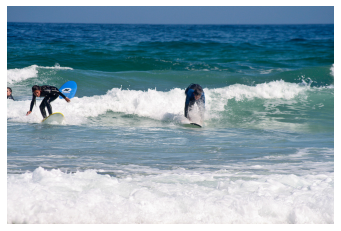

We show an example for which we obtained an high score result
ground truth answers
{'question_type': 'what', 'multiple_choice_answer': 'microwave', 'answers': [{'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'microwave', 'answer_confidence': 'yes', 'answer_id': 10}], 'image_id': 321242, 'answer_type': 'other', 'question_id': 321242006}
Question: What appliance is visible?
Answer 1: microwave
Answer 2: microwave
A

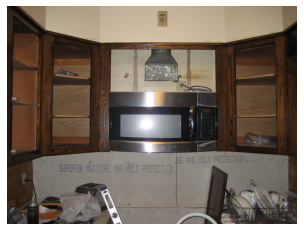

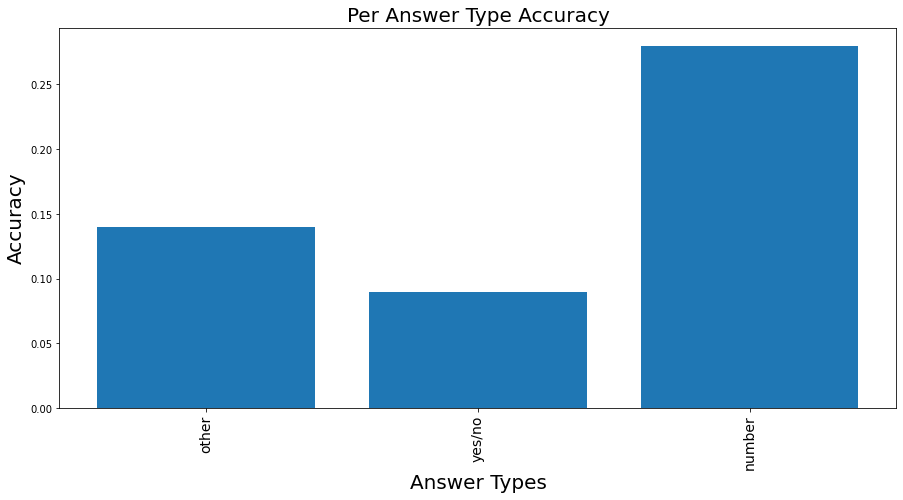

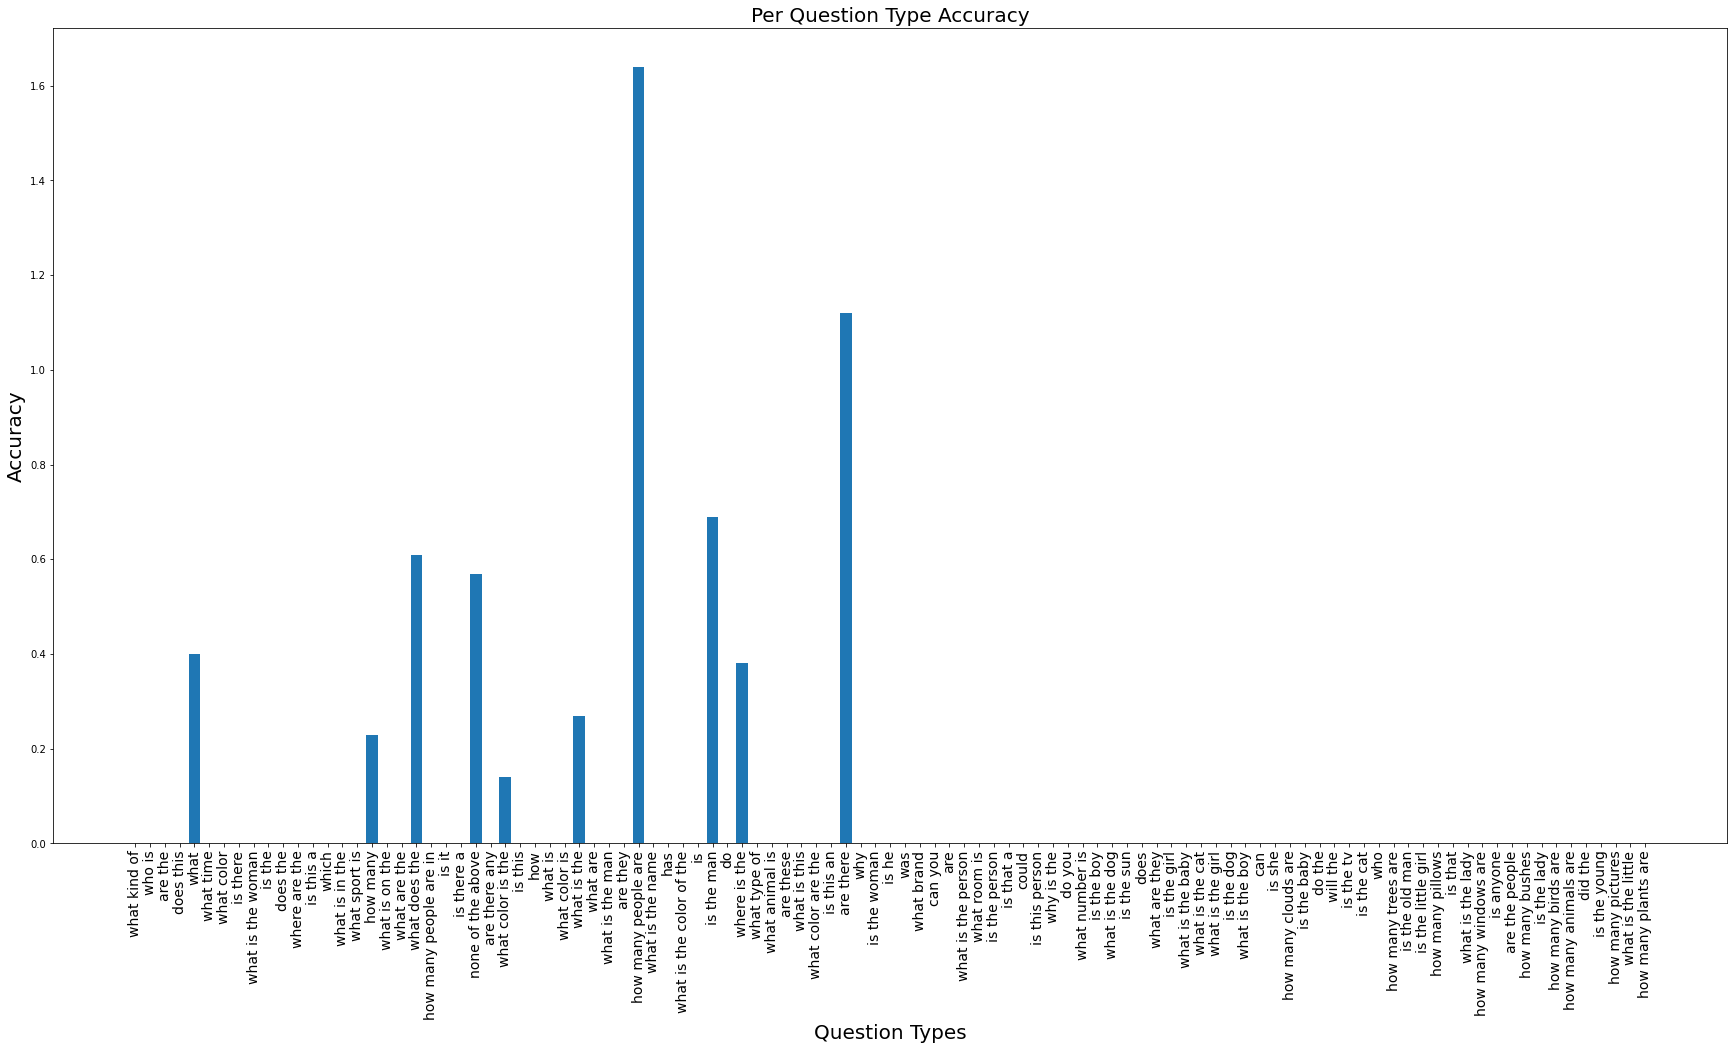

In [ ]:
if APPROACH == 'random':
  with open(random_baseline_path, 'r') as f:
    res = json.load(f)

  evaluate_results(vqa_coco, vqa_abs, random_baseline_path, n=2)

We can see that the random baseline leads to very poor results due to the variety of possible answers that are present in this task. In general, the accuracies per answer type (yes/no, other, number) are all below 0.3%. By looking at the accuracies per question type, instead, just for questions starting with "Are there..." and "How many people are..." the accuracy values go above 1%. The overall accuracy is just 0.14%.

## PRIOR YES BASELINE
We predict 'yes' for every sample. As explained in VQA: Visual Question Answering by Aishwarya Agrawal∗, Jiasen Lu∗, Stanislaw Antol∗, Margaret Mitchell, C. Lawrence Zitnick, Dhruv Batra, and Devi Parikh (https://arxiv.org/pdf/1505.00468v7.pdf) and as showed in the last cell of the *Dataset analysis* section of this notebook, many questions (38%) in the dataset are answered with a 'yes' or a 'no' and, among the 'yes'/'no' questions, there is a bias towards 'yes'.

### Computing the predictions

In [ ]:
if APPROACH == 'prior_yes':
  qa_dm = VisualQADataModule(train_dataset, val_dataset, train_archives, val_archives)
  qa_dm.setup('test')

  res = []
  tot_n = 0

  for image_filenames, question_ids, questions, labels in qa_dm.test_dataloader():

      for i in range(len(image_filenames)):
        tot_n += 1
        res.append({'image_filename': image_filenames[i], 'question_id': question_ids[i].item(), 'answer': 'yes'})

  assert len(res) == tot_n

  with open(prior_yes_path, 'w') as f:
    json.dump(list(res), f)

### Evaluating the results

computing accuracy
Finished Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 24.99

Per Question Type Accuracy is the following:
what kind of : 0.00
who is : 0.00
are the : 58.74
does this : 69.59
what : 0.59
what time : 0.00
what color : 0.00
is there : 62.14
what is the woman : 0.00
is the : 54.16
does the : 71.03
where are the : 2.20
is this a : 54.66
which : 0.69
what is in the : 0.00
what sport is : 0.00
how many : 0.26
what is on the : 0.00
what are the : 0.24
what does the : 0.00
how many people are in : 0.00
is it : 54.18
is there a : 57.53
none of the above : 40.14
are there any : 40.43
what color is the : 0.00
is this : 56.82
how : 3.61
what is : 1.24
what color is : 0.00
what is the : 0.82
what are : 1.22
what is the man : 0.88
are they : 69.55
how many people are : 0.00
what is the name : 1.25
has : 67.83
what is the color of the : 0.00
is : 58.21
is the man : 63.22
do : 79.25
where is the : 3.40
what type of : 0.00
what animal is : 1.76
ar

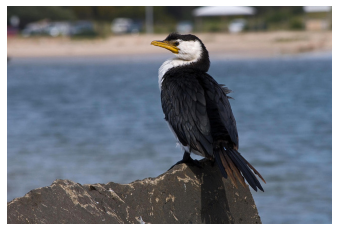

We show an example for which we obtained an high score result
ground truth answers
{'question_type': 'is', 'multiple_choice_answer': 'yes', 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'yes', 'answer_confidence': 'no', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}], 'image_id': 563909, 'answer_type': 'yes/no', 'question_id': 563909002}
Question: Is she happy to be eating?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: yes
Answer 7: yes
Answer 8: y

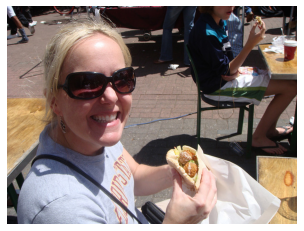

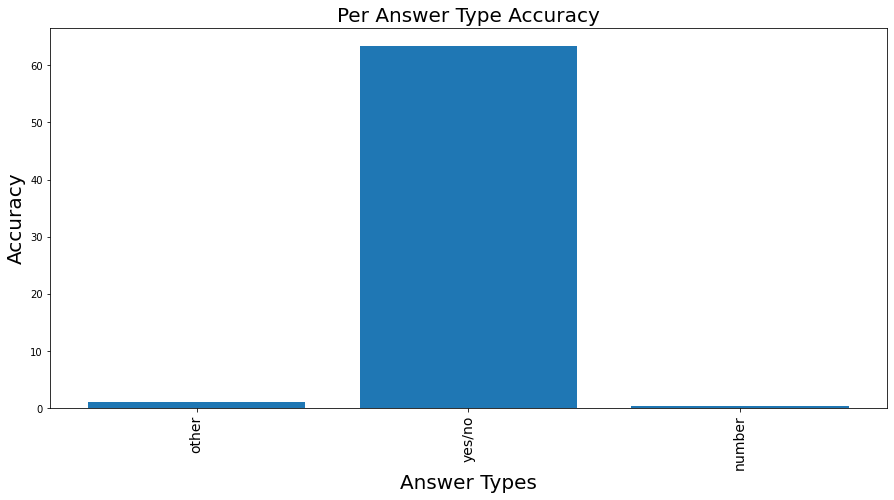

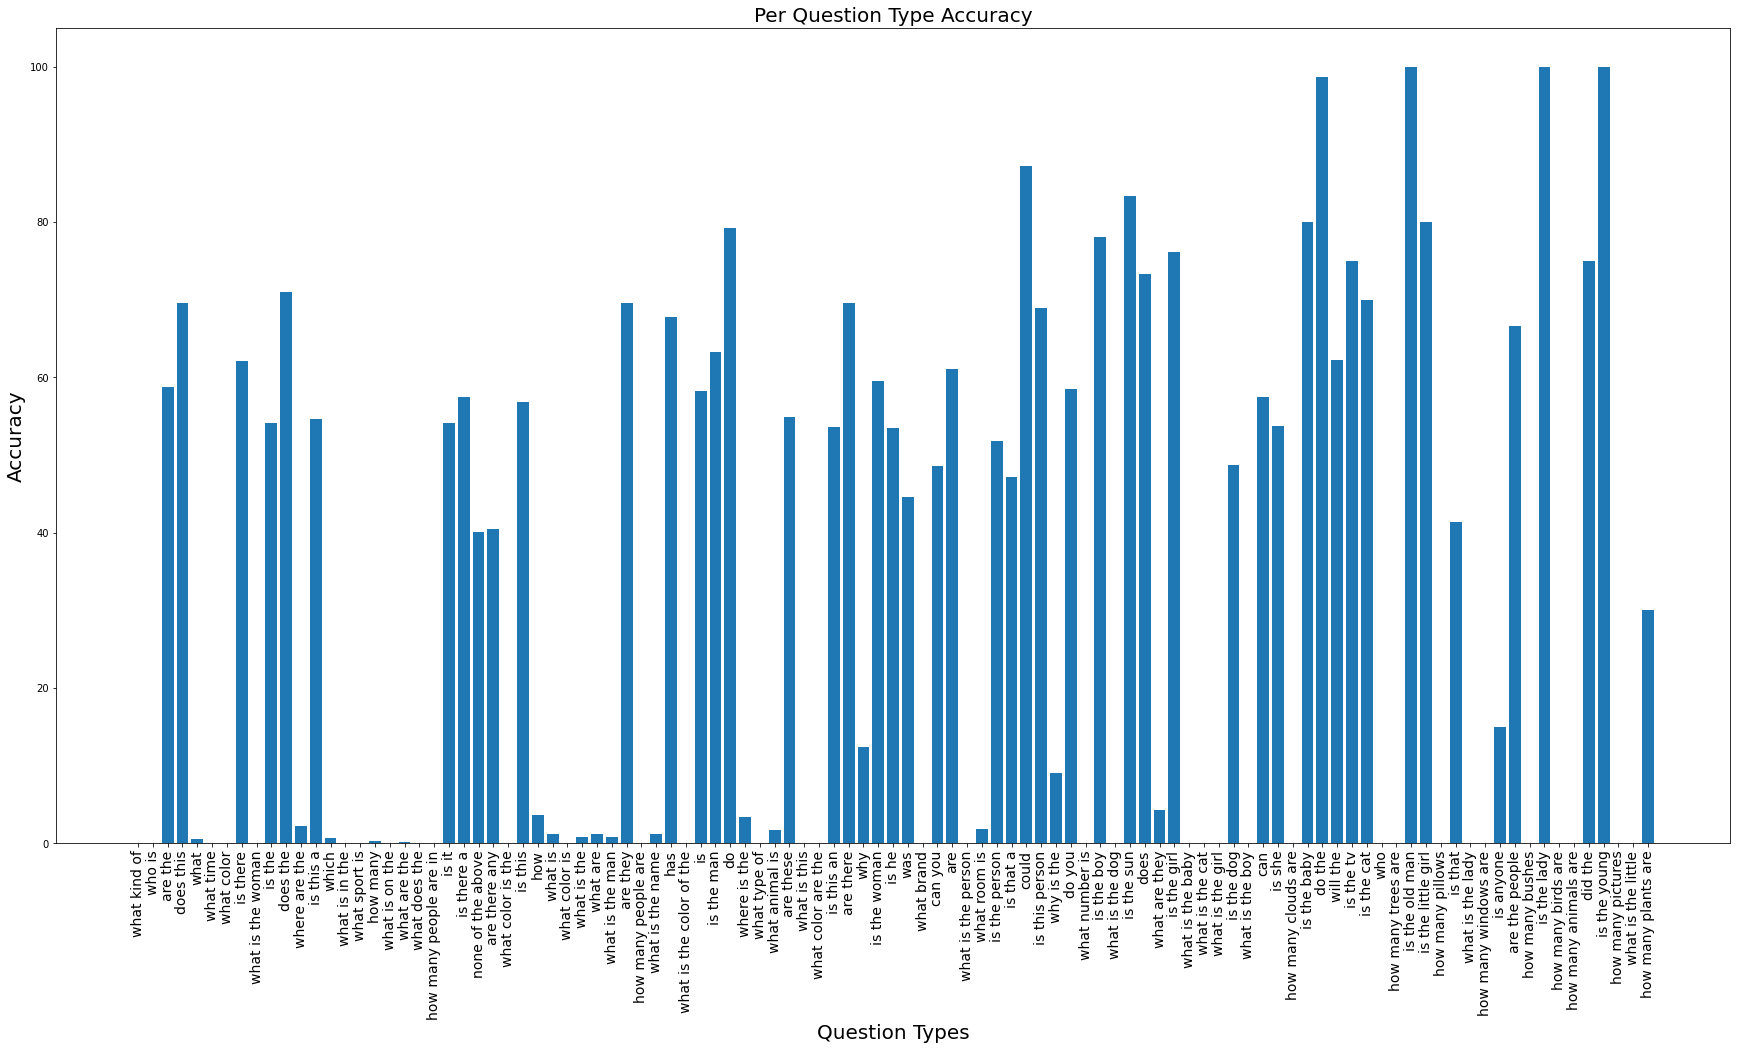

In [ ]:
if APPROACH == 'prior_yes':
  with open(prior_yes_path, 'r') as f:
    res = json.load(f)

  evaluate_results(vqa_coco, vqa_abs, prior_yes_path, n=2)

As expected, since many questions can be answered with a yes or no, the overall accuracy that we reach, 24.99%, is higher than the one obtained with the random baseline. Clearly, even in this case, the accuracy for answers *other* and *number* are very low, but the accuracy for questions with *yes/no* answers is 63.43% since, as specified before, among the questions with yes/no answers there is a bias towards yes.

## APPROACH 1 - CNN + LSTM
We develop a 2-channel vision (image) + language (question) model that outputs the most probable answer across the K most frequent ones in the training dataset. The model has been initially implemented following https://arxiv.org/pdf/1505.00468v7.pdf.

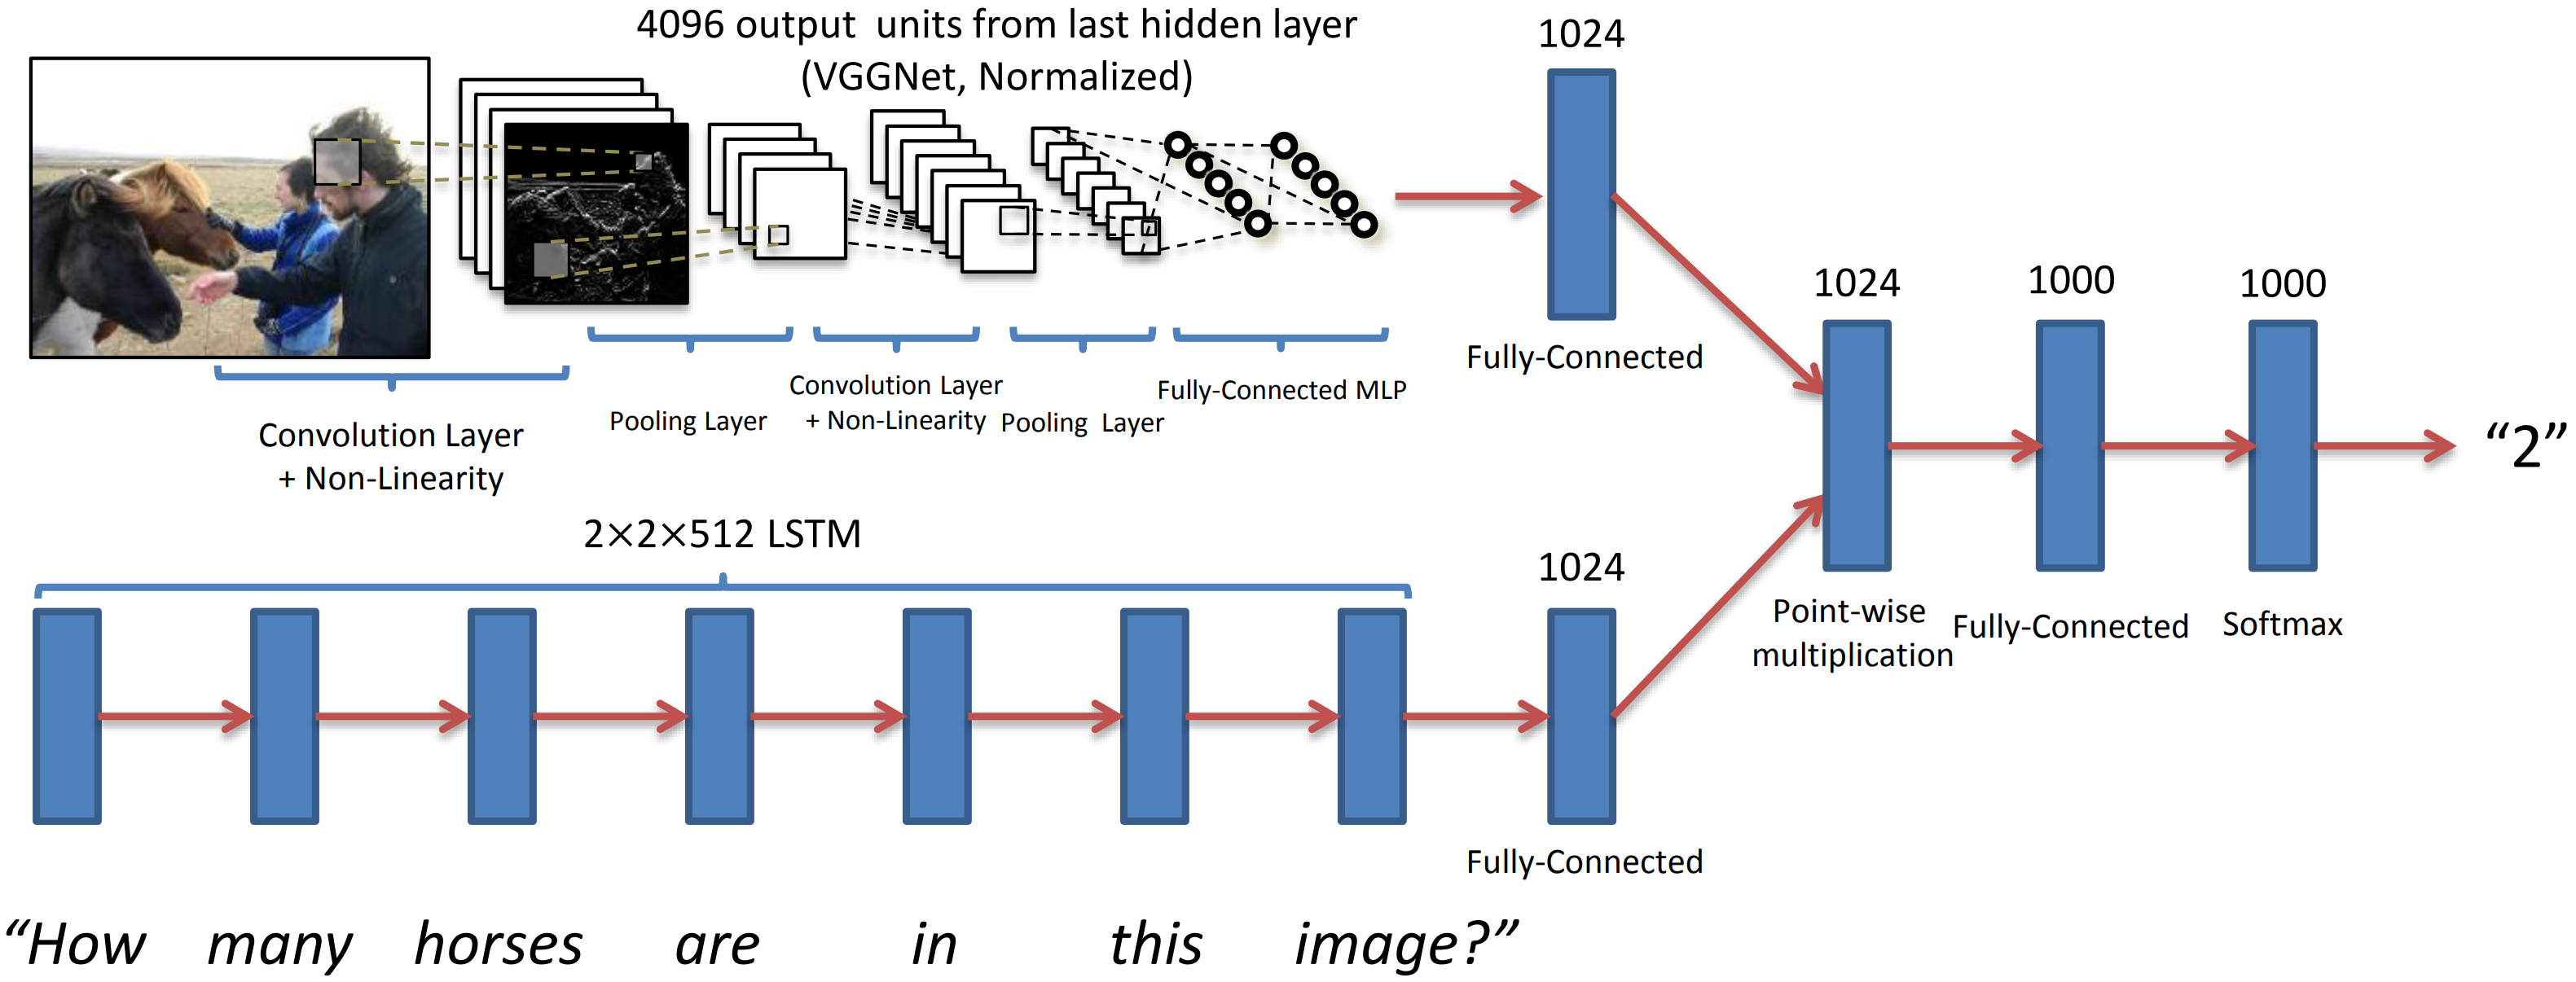

The image channel is represented by pre-trained VGG, from which we extract the activation values of the last hidden layer, that are l2 normalized and are used as 4096-dim image embeddings. The image embedding is then transformed to 1024-dim by a fully connected layer with tanh non-linearity.

The question channel, instead, is represented by a LSTM with two hidden layers. Differently from the reference paper, in which the input vocabulary to the embedding layer is made up by all the question words seen in the training dataset, we have directly used pre-trained Glove embeddings (in particular, 50-dim and 300-dim embeddings). The last cell state and the last hidden state representations from each of the two hidden layers are concatenated to obtain the question embedding, that is 2048-dimensional. Again, we use a linear layer with tanh non-linearity to transform it to a 1024-dim embedding. 

The image and question embeddings, which have the same size, are combined through element-wise multiplication. The combined embedding is passed to an MLP with a linear layer of 1000 hidden units followed by tanh non-linearity and 0.5 dropout, and a final layer with K units followed by the softmax activation function, to obtain a probability distribution over the K most frequent answers.

In the *global variables* section, we defined K=1000.

### Building the dataset

In [ ]:
# Maps each word in the question to the corresponding index in GloVe dictionary
def sentence2idx(question:str):
  return torch.tensor([word_idxs_glove[word] for word in word_tokenize(question) if word in word_idxs_glove], dtype=torch.long)

In [ ]:
if APPROACH == "approach_1":
  qa_dm = VisualQADataModule(train_dataset, val_dataset, train_archives, val_archives, feature_extraction_function=sentence2idx)
  qa_dm.setup('train')

100%|██████████| 47885/47885 [00:09<00:00, 5246.72it/s]


### Building the model

In [ ]:
# This function extracts image features from VGG pretrained model

def get_vgg_features(model, image):
  # 1. Choose the layer we are interested in
  layer = model._modules.get('classifier')[5]

  # 2. Create a PyTorch Variable with the transformed image
  t_img = Variable(image)

  # 3. Create a vector of zeros that will hold our feature vector
  my_embedding = torch.zeros((image.shape[0], 4096))

  # 4. Define a function that will copy the output of the layer
  def copy_data(m, i, o):
    #print(o.data.squeeze().shape)
    my_embedding.copy_(o.data.squeeze())

  # 5. Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)

  # 6. Run the model on our transformed image
  model(t_img)

  # 7. Detach our copy function from the layer
  h.remove()

  # 8. Return the feature vector
  return my_embedding.to(device)

In [ ]:
class MyModel(Module):
  def __init__(self, word_vectors):
    super().__init__()

    # Image embedding
    self.vgg = models.vgg16(pretrained=True)
    for param in self.vgg.features.parameters():
      param.requires_grad = False
    self.vgg.eval()

    # Linear layer to reshape image embeddings from 4096 to 1024
    self.image_lin = Linear(4096, 1024)
    
    # Language embedding
    self.embedding = torch.nn.Embedding.from_pretrained(word_vectors, padding_idx=0, freeze=True)
    self.lstm = torch.nn.LSTM(input_size=word_vectors.size(1), hidden_size=512,
                             bidirectional=False, num_layers=2, batch_first=True, dropout=0.0)

    # Linear layer to reshape question embeddings from 4096 to 1024
    self.text_lin = Linear(2048, 1024)

    self.lin1 = Linear(1024, 1000)
    self.lin2 = Linear(1000, 1000)

    self.dropout = Dropout(p=0.5)
    self.tanh = Tanh()
    self.softmax = Softmax()

  def forward(self, images, questions):
    # Get image features from the last hidden layer of VGGNet 
    image_emb = get_vgg_features(self.vgg, images)

    # l2 normalized activations from the last hidden layer of VGGNet
    image_emb =  image_emb / torch.norm(image_emb, p=2, dim=1, keepdim=True).to(device)
    
    # Linear layer to reshape image embeddings from 4096 to 1024 with tanh activation
    image_emb = self.image_lin(image_emb)
    image_emb = self.tanh(image_emb)

    # Get embeddings from Glove, Word2vec or mixed dictionary
    quest_emb = self.embedding(questions)

    # Give them as input to an LSTM
    output, (h_n, c_n) = self.lstm(quest_emb)
    
    # The question embedding is obtained as a concatenation of the
    # last cell state and last hidden state representations for each
    # of the two hidden layers of the LSTM
    text_emb = torch.cat([h_n, c_n], dim=2)
    emb_1 = text_emb[0]
    emb_2 = text_emb[1]
    text_emb = torch.cat([emb_1, emb_2], dim=1)

    # Linear layer to reshape text embedding to from 2048 to 1024 with tanh activation
    text_emb = self.text_lin(text_emb)
    text_emb = self.tanh(text_emb)

    # Get embedding of all information with elementwise multiplication of 
    # the image and question embeddings
    embedding = torch.mul(image_emb, text_emb)

    # " MLP - a fully connected neural network classifier with 2
    # hidden layers and 1000 hidden units (dropout 0.5) in each layer
    # with tanh non-linearity, followed by a softmax layer to obtain
    # a distribution over K answers. "
    # See https://arxiv.org/pdf/1505.00468v7.pdf for reference.
    out = self.lin1(embedding)
    out = self.dropout(out)
    out = self.tanh(out)

    out = self.lin2(out)
    out = self.softmax(out)

    return out

According to https://arxiv.org/pdf/1708.00584.pdf, cross entropy loss function has been used.

None of the papers and repositories that implement the CNN+LSTM approach use the preferences that are provided together with the answers. They consider as ground truth answer for a given question the most frequent one. Therefore, if the model predicts one of the other possible answers, it will be considered as completely wrong. For this reason, in addition to reproducing the training with this standard loss, we propose a novel loss leveraging preferences.

In particular, we define the ground truth for a certain question as a vector of K elements where the elements corresponding to a possible answer are set to 0, 0.5, or 1, depending on whether they have preference 'no', 'maybe', or 'yes', respectively. In this way, we consider all possible answers, but we take into account the fact that some of them may be potentially wrong, by weighting them differently.

In [ ]:
class Classifier(pl.LightningModule):
  def __init__(self, word_vectors):
    super().__init__()

    self.model = MyModel(word_vectors).to(device)
    self.loss_fn = CrossEntropyLoss()

    self.test_result = []

  def forward(self, images, questions, answers=None, preferences=None):
    out = self.model(images.to(device), questions.to(device))

    result = {'logits': out}

    if answers is not None:
      result['labels'] = answers
      loss = self.loss(out, answers, preferences)
      result['loss'] = loss

    return result
  
  def training_step(self, batch, batch_idx: int) -> torch.Tensor:
    images = retrieve_batch_images(batch[0], True)

    forward_output = self.forward(images, batch[2], batch[4], batch[3]) # images, questions, labels, preferences  
    batch_loss = forward_output['loss']

    self.log('train_loss', batch_loss, prog_bar=True)
    return batch_loss

  def validation_step(self, batch: Tuple[torch.Tensor], batch_idx: int):
    images = retrieve_batch_images(batch[0], False)

    forward_output = self.forward(images, batch[2], batch[4], batch[3])
    batch_logits = forward_output['logits']
    labels = forward_output['labels']
    loss = forward_output['loss']

    predictions = torch.argmax(batch_logits, axis=1)
    self.log('val_loss', loss, prog_bar=True)
    
    return {"loss": loss, "predictions": predictions, "labels": labels}

  def test_step(self, batch: Tuple[torch.Tensor], batch_idx: int):
    images = retrieve_batch_images(batch[0], False)

    forward_output = self.forward(images, batch[2], batch[4], batch[3])
    batch_logits = forward_output['logits']
    labels = forward_output['labels']
    loss = forward_output['loss']

    predictions = torch.argmax(batch_logits, axis=1)
    self.log('test_loss', loss, prog_bar=True)

    for i, prediction in enumerate(predictions):
      answ = le.inverse_transform([prediction])[0]
      self.test_result.append({'image_filename': batch[i][0], 'question_id': batch[i][1], 'answer': answ})
    
    return {"loss": loss, "predictions": predictions, "labels": labels}

  
  def loss(self, pred, answers, preferences):
    ys = [] # vector of 1000 elements for each sample in the batch

    if USE_PREFERENCES:
      for i, answer in enumerate(answers):   # answers is the list of answers of each element in batch
        y = [0 for i in range(1000)] 
        for j, idx in enumerate(answer):     # answer is the list of indices of the answers in the list of the K most frequent answers
          if idx == -1:
            continue
          y[idx] = preferences[i][j]
        ys.append(torch.tensor(y))           # list of dim_batch lists

    else:  # loss as it is computed in all papers and repositories implementing this approach
      for i, answer in enumerate(answers):   # answers is the list of answers of each element in batch
        dic = {}
        for j, idx in enumerate(answer):     # answer is the list of indices of the answers in the list of the K most frequent answers
          if idx == -1:
            continue
          if idx in dic.keys():
            dic[idx] += 1
          else:
            dic[idx] = 1
        
        # We are computing the index of the most frequent answer given to a certain question
        most_freq_ans_idx = max(dic, key=dic.get)

        ys.append(most_freq_ans_idx)  # list of dim_batch lists

    if USE_PREFERENCES:
      ys = torch.stack(ys)
    else:
      ys = torch.tensor(ys)

    return self.loss_fn(pred, ys.to(device))

  def configure_optimizers(self):
    params = list(self.model.named_parameters())
    optimizer = Adam([p for n,p in params if p.requires_grad], lr=0.0001)
    return optimizer

In [ ]:
if APPROACH == 'approach_1':
  model = Classifier(word_vectors=word_vectors_glove).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

###Training the model

In [ ]:
def get_trainer(ckpt_dir: str) -> pl.Trainer:
  
  early_stopping = pl.callbacks.EarlyStopping(
  monitor='val_loss', # the value that will be evaluated to activate the early stopping of the model.
  patience=2, # the number of consecutive attempts that the model has to raise (or lower depending on the metric used) to raise the "monitor" value.
  verbose=True, # whether to log or not information in the console.
  mode='min', # wheter we want to maximize (max) or minimize the "monitor" value.
  )
  
  
  checkpoint_callback = pl.callbacks.ModelCheckpoint(
  monitor='val_loss', # the value that we want to use for model selection.
  verbose=True, # whether to log or not information in the console.
  save_top_k=3, # the number of checkpoints we want to store.
  mode='min', # wheter we want to maximize (max) or minimize the "monitor" value.
  dirpath=ckpt_dir, # output directory path
  filename='{epoch}-{val_f1:.4f}' # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
  )
  

  # the PyTorch Lightning Trainer
  trainer = pl.Trainer(
  max_epochs=5, # maximum number of epochs.
  gpus=1, # the number of gpus we have at our disposal.
  progress_bar_refresh_rate=50,
  callbacks=[], # the callback we want our trainer to use.
  #accelerator=device
  )
  
  return trainer

In [ ]:
if APPROACH == 'approach_1':
  if PRETRAINED:
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

  trainer = get_trainer(path_trainer)

  trainer.fit(model=model, datamodule=qa_dm)

In [ ]:
if APPROACH == 'approach_1':
  # saving the model
  torch.save(model.state_dict(), model_path)

### Evaluating the model

In [ ]:
if APPROACH == 'approach_1':
  qa_dm.setup('test')

In [ ]:
if APPROACH == 'approach_1':
  # Initializing the model and loading pretrained weights
  model = Classifier(word_vectors=word_vectors_glove).to(device)
  model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
  model.eval()

In [ ]:
# This function gets the output predictions for each sample in the test set and saves it
def evaluate(test_dataloader, model, output_path):
  res = []
  tot_n = 0

  for image_filenames, question_ids, questions, preferences, labels in tqdm(test_dataloader):
    images = retrieve_batch_images(image_filenames, False)
    
    out = model(images, questions)
    logits = out['logits']

    predictions = torch.argmax(logits.cpu(), axis=1)
    predictions = le.inverse_transform(predictions)   # to transform the index of the 1000 most frequent answers in a word.

    for i in range(len(image_filenames)):
      tot_n += 1
      res.append({'image_filename': image_filenames[i], 'question_id': question_ids[i], 'answer': predictions[i]})

  with open(output_path, 'w') as f:
      json.dump(list(res), f)

In [ ]:
if APPROACH == 'approach_1':
  # Compute and save the model's predictions over the test set
  evaluate(qa_dm.test_dataloader(), model, results_path)

In [ ]:
if APPROACH == 'approach_1':
  # Evaluate the results over the test set
  evaluate_results(vqa_coco, vqa_abs, results_path, n=2)

In [ ]:
if APPROACH == 'approach_1':
  # Check whether the model predicts something different than yes or no
  for elem in res:
    if elem['answer'] != 'yes' and elem['answer'] != 'no':
      print(elem['answer'])

### Evaluated models
Here we report the evaluation of several trained models.

In [ ]:
if APPROACH == 'approach_1':
  qa_dm = VisualQADataModule(train_dataset, val_dataset, train_archives, val_archives, feature_extraction_function=sentence2idx)
  qa_dm.setup('test')

100%|██████████| 23207/23207 [00:04<00:00, 5458.56it/s]


In [ ]:
if APPROACH == 'approach_1':
  # Initializing the model and loading pretrained weights
  model = Classifier(word_vectors=word_vectors_glove).to(device)
  model.load_state_dict(torch.load('/content/drive/MyDrive/DL_PROJECT_local/models/approach_1_glove300d_prefFalse.pth', map_location=torch.device(device)))
  model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Model trained without preferences
These are the results obtained with the model that has been trained considering as label of each sample the most frequent answer among the possible ones, without considering preferences and using 300-dimensional GloVe embeddings.
Here we are using the standard loss.

In [ ]:
if APPROACH == 'approach_1':
  # Compute and save the model's predictions over the test set
  evaluate(qa_dm.test_dataloader(), model, '/content/drive/MyDrive/DL_PROJECT_local/results/approach_1_glove300d_prefFalse.json')

100%|██████████| 3481/3481 [04:33<00:00, 12.75it/s]


computing accuracy
Finished Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 25.79

Per Question Type Accuracy is the following:
how many : 0.22
how many people are in : 0.00
what is the woman : 1.54
what : 0.74
are the : 61.85
is this a : 51.91
what are the : 0.00
is the : 57.82
is this : 58.16
is it : 61.50
what color is : 0.00
why : 13.96
what is the : 0.75
what kind of : 0.00
are : 61.08
is the woman : 50.00
what is the man : 1.25
what is the name : 5.00
what is : 0.82
can you : 57.71
has : 68.06
is there : 53.88
is this an : 67.94
what is in the : 1.09
none of the above : 39.21
are these : 64.32
what color : 0.00
does the : 64.22
is there a : 54.91
what time : 0.00
what animal is : 1.88
what type of : 0.00
how : 2.28
where is the : 3.68
are there : 68.97
what is this : 0.00
what color are the : 0.00
what color is the : 0.13
what does the : 0.00
which : 0.00
what is on the : 0.00
is : 55.46
does this : 68.06
could : 80.00
who is : 0.00
is the man :

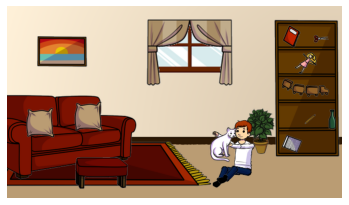

We show an example for which we obtained an high score result
ground truth answers
{'answer_type': 'yes/no', 'multiple_choice_answer': 'no', 'answers': [{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 3}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 8}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'no', 'answer_confidence': 'no', 'answer_id': 10}], 'image_id': 405945, 'question_type': 'is', 'question_id': 405945000}
Question: Is that art?
Answer 1: no
Answer 2: no
Answer 3: yes
Answer 4: no
Answer 5: no
Answer 6: no
Answer 7: no
Answer 8: yes
Answer 9: yes
Answer 

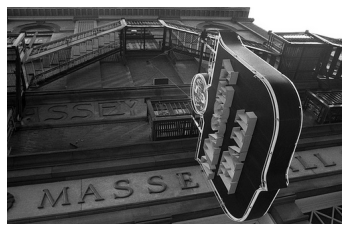

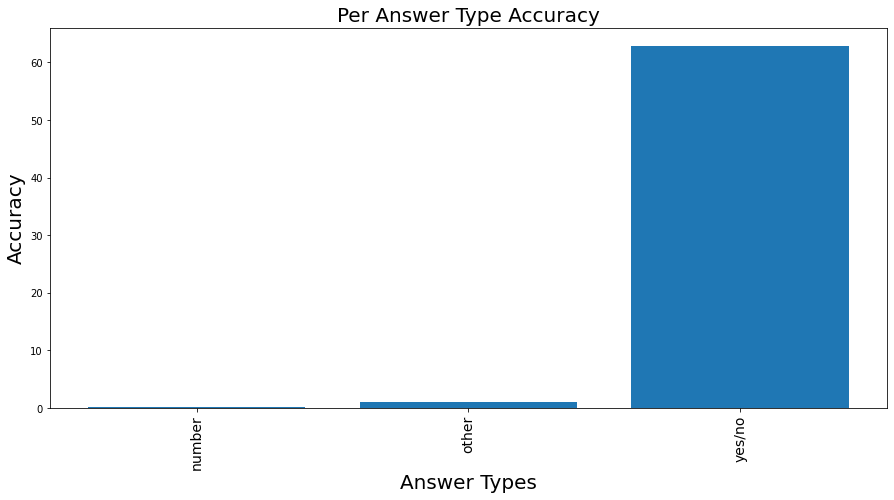

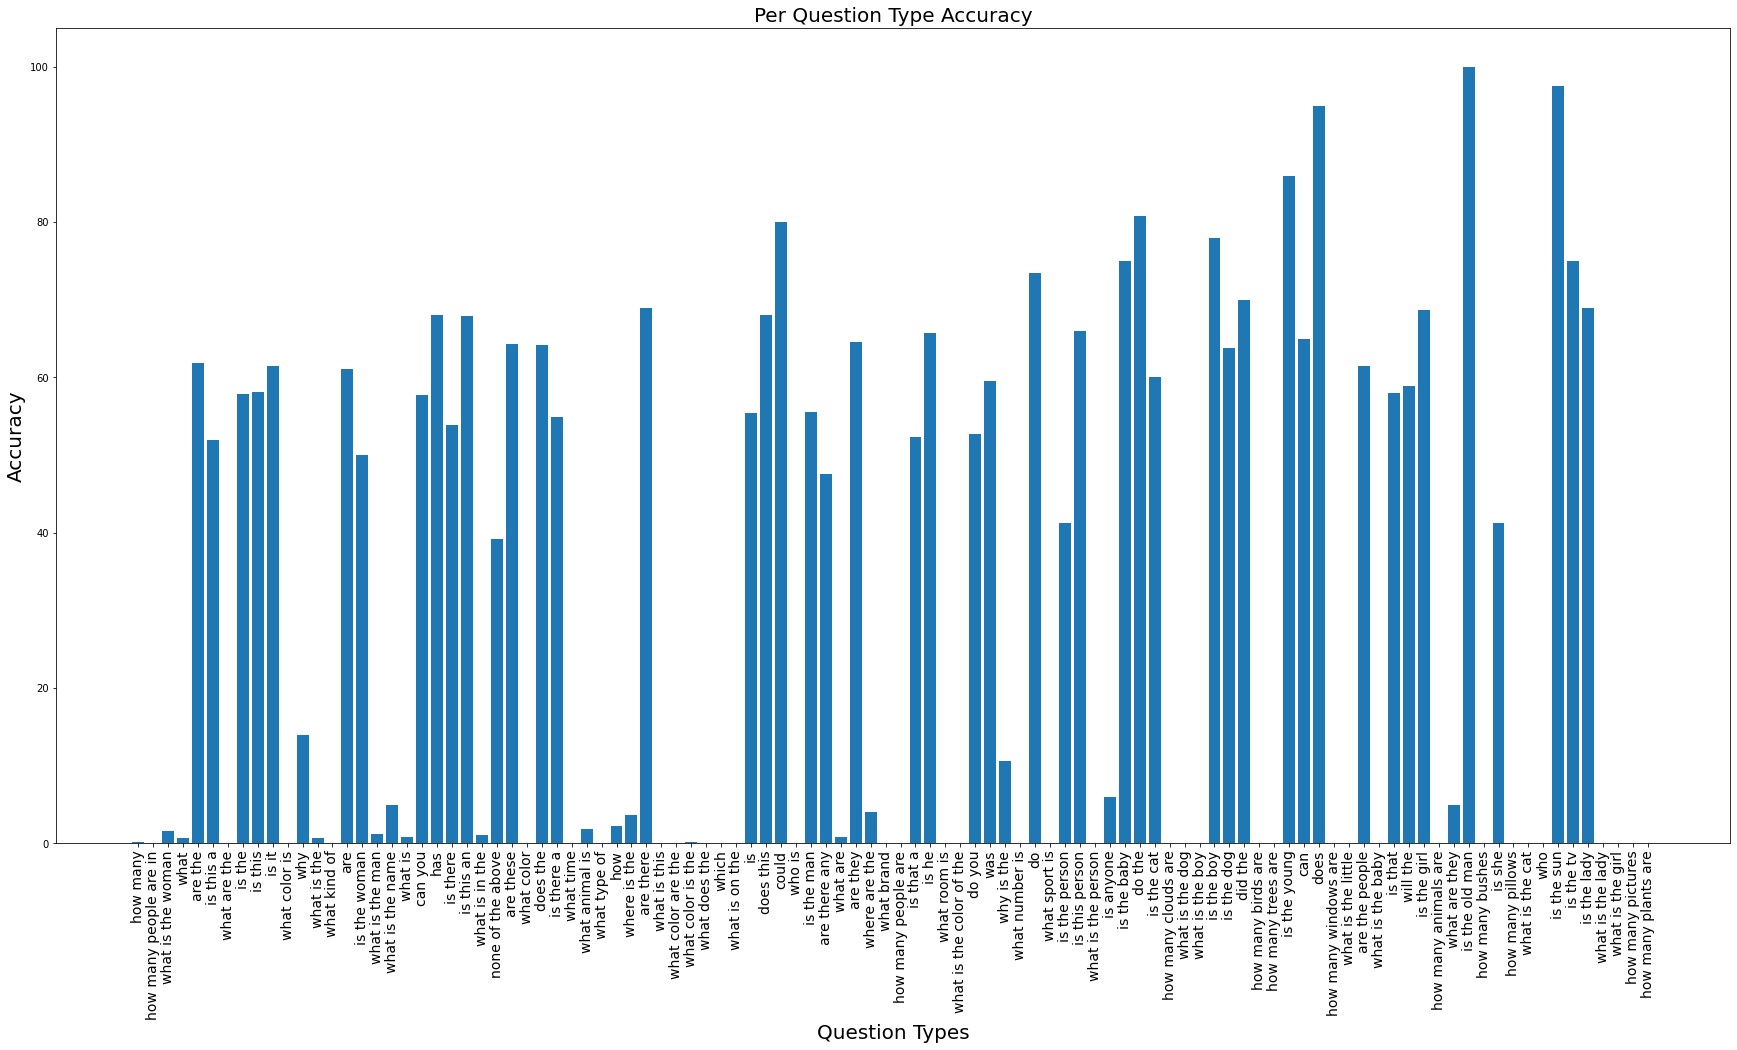

In [ ]:
if APPROACH == 'approach_1':
  # Evaluate the results over the test set
  evaluate_results(vqa_coco, vqa_abs, results_path, n=2)

In [ ]:
if APPROACH == 'approach_1':
  with open('/content/drive/MyDrive/DL_PROJECT_local/results/approach_1_glove300d_prefFalse.json', 'r') as f:
    res = json.load(f)
  # Check whether the model predicts something different than yes or no
  n = 0
  for elem in res:
    if elem['answer'] != 'yes' and elem['answer'] != 'no':
      print(elem['answer'])
      n += 1

  print(f'There are {n} predictions different from yes or no.')

There are 0 predictions different from yes or no.


Because of the limited resources at our disposal (RAM limit), we managed to train the model for just 3 epochs. This is clearly not enough to obtain satisfying results. However, even with such a short training, we manage to overcome the performances obtained with both trivial baselines. In fact, the overall accuracy is 25.79%.

#### Model trained with preferences
This model  has been trained using preferences in the loss computation and 300-dimensional GloVe embeddings in the embedding layer. Here we are using our novel loss.

In [ ]:
if APPROACH == 'approach_1':
  # Compute and save the model's predictions over the test set
  evaluate(qa_dm.test_dataloader(), model, '/content/drive/MyDrive/DL/Project/results/cnn_lstm.json')

100%|██████████| 3481/3481 [03:02<00:00, 19.05it/s]


computing accuracy
Finished Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 26.45

Per Question Type Accuracy is the following:
what kind of : 0.20
how many : 0.22
what : 0.95
are the : 60.05
who is : 0.00
are these : 65.80
does this : 69.52
is this : 59.33
how many people are : 0.00
what are the : 0.00
is there : 60.92
is this a : 61.24
do : 65.53
could : 77.27
is the : 58.49
what color is the : 0.06
is the woman : 54.48
does the : 65.32
what is : 0.66
are they : 62.28
which : 0.45
are there : 68.66
what is the : 0.56
are : 55.18
what does the : 0.00
how many people are in : 0.00
is the man : 60.00
what is the woman : 1.54
none of the above : 40.29
what is on the : 0.00
what color are the : 0.00
what is this : 0.00
was : 59.17
has : 65.81
what color is : 0.00
is : 62.68
what room is : 0.00
is there a : 58.61
is this person : 60.80
is it : 61.15
why : 12.08
what time : 0.00
can you : 64.57
what is the man : 1.25
why is the : 10.59
what type of : 0.00


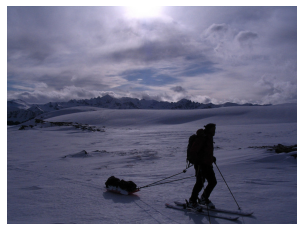

We show an example for which we obtained an high score result
ground truth answers
{'question_type': 'is there a', 'multiple_choice_answer': 'yes', 'answers': [{'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}], 'image_id': 484397, 'answer_type': 'yes/no', 'question_id': 484397001}
Question: Is there a person in the picture?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: yes
Answer 

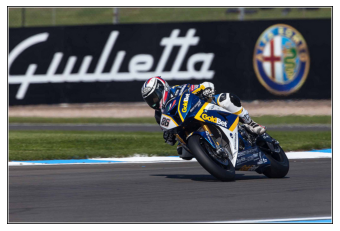

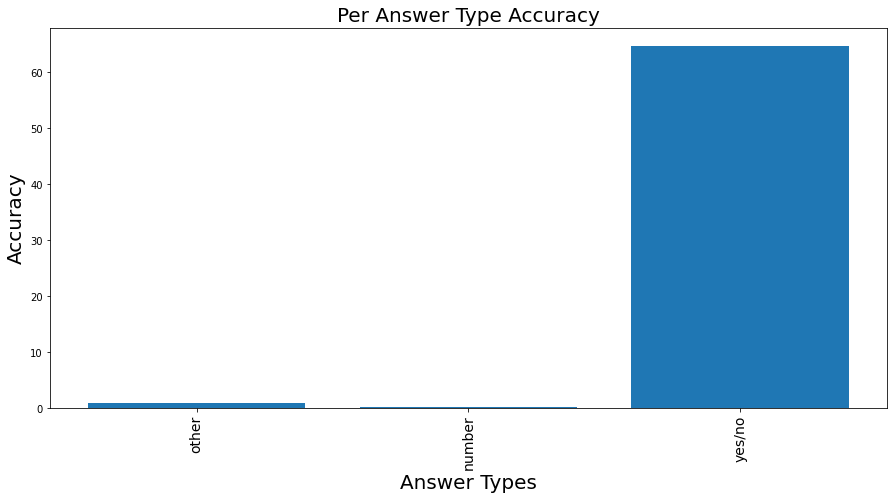

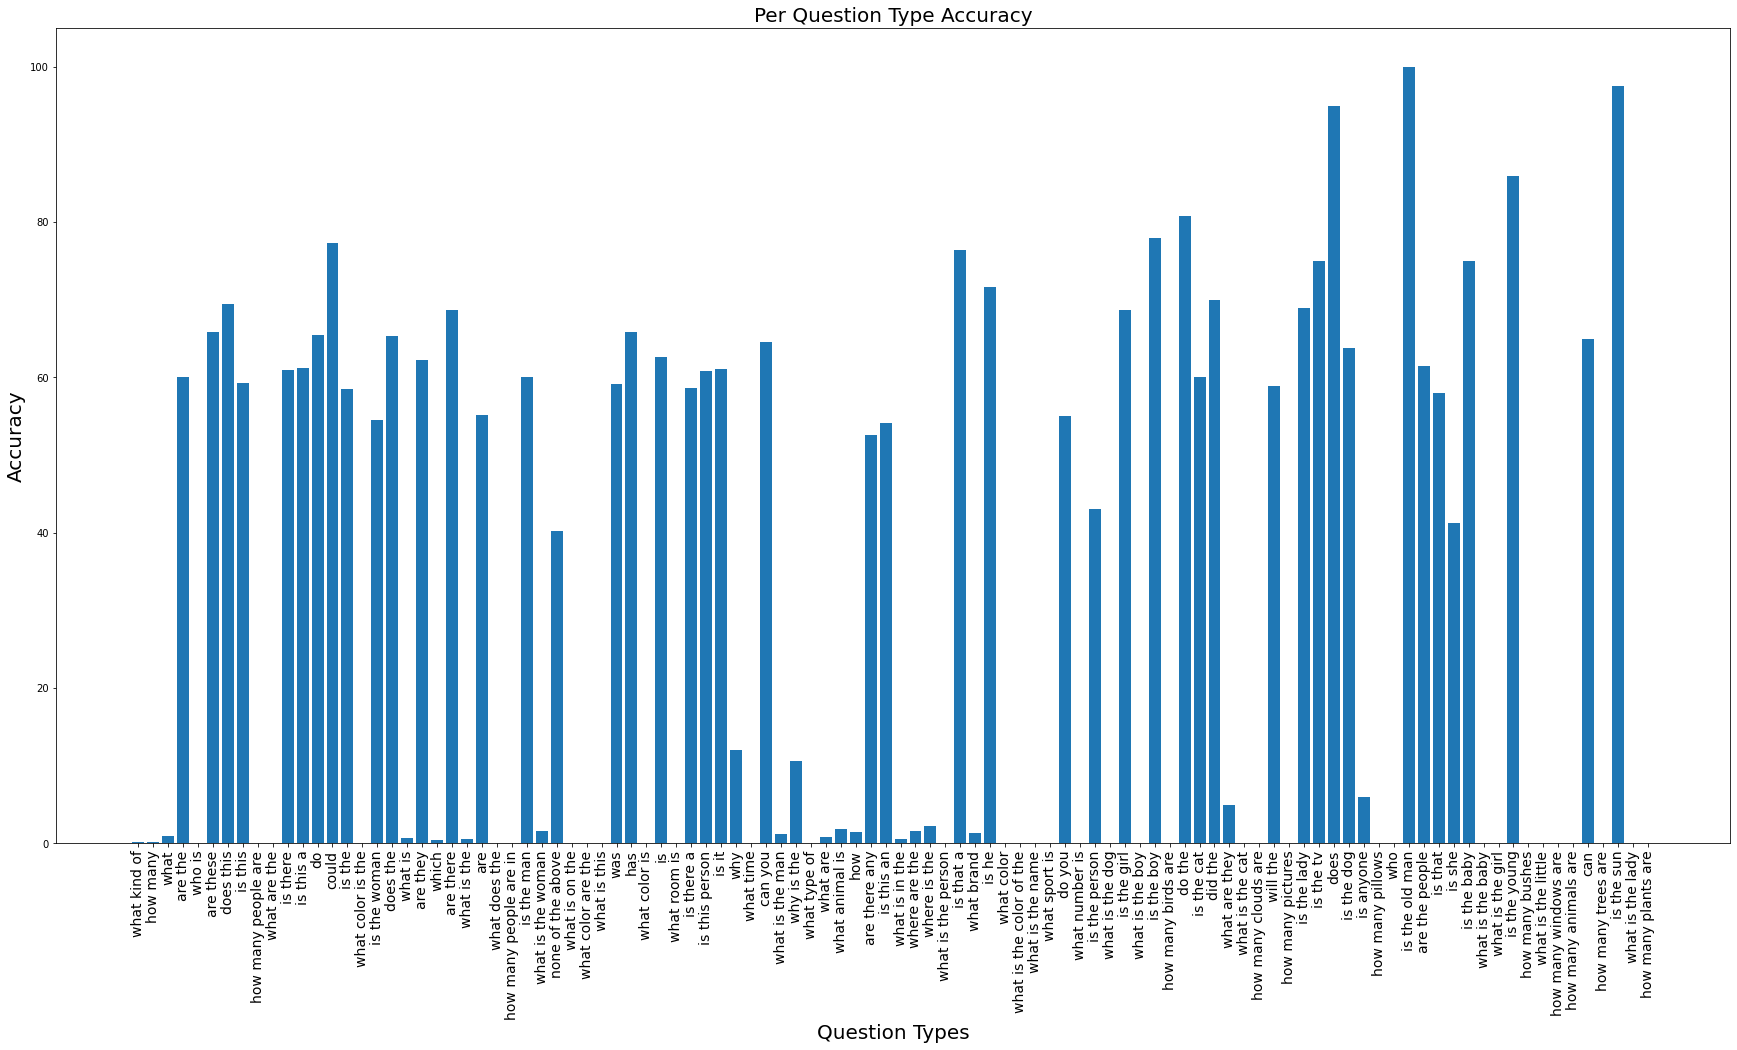

In [ ]:
if APPROACH == 'approach_1':
  # Evaluate the results over the test set
  evaluate_results(vqa_coco, vqa_abs, '/content/drive/MyDrive/DL/Project/results/cnn_lstm.json', n=2)

In [ ]:
if APPROACH == 'approach_1':
  with open('/content/drive/MyDrive/DL/Project/results/cnn_lstm.json', 'r') as f:
    res = json.load(f)
  # Check whether the model predicts something different than yes or no
  n = 0
  for elem in res:
    if elem['answer'] != 'yes' and elem['answer'] != 'no':
      print(elem['answer'])
      n += 1

  print(f'There are {n} predictions different from yes or no.')

There are 0 predictions different from yes or no.


As we can see, despite training the model for just 3 epochs, using preferences seems to improve the training, leading to slightly higher overall accuracy of 26.45%. However, due to the impossibility of training the model for a sufficiently large number of epochs, we do not know how the training will evolve and if it will actually lead to better results.

#### Models trained with 50-dimensional GloVe embeddings
We have tried using smaller embeddings to see whether we managed to train the model for more epochs, thus reaching better results. However, the training was still very heavy and did not allow us to reach higher performances. For this reason, we leave here just the results obtained using the 300-dimensional embeddings.

## APPROACH 2 - Generative LXMERT
https://gavinguan95.github.io/files/Generative_Visual_Question_Answering_using_Cross-Modal_Visual-Linguistic_Embeddings.pdf

This paper extends LXMERT, which is treated as a multimodal encoder, with a decoder that allows to generate text. LXMERT receives as input the features and bounding boxes computed using a FasterRCNN on the images and the input_ids, token_type_ids and attention_mask obtained by applying LxmertTokenizer to questions. FasterRCNN, LXMERT model and LxmertTokenizer are used as pre-trained, without performing any additional training epoch. LXMERT produces a final hidden representation that contains information from both the image and the question. This is passed to a bridging layer, which transforms it into a form amenable for our decoder.

The decoder consists of a 3-layer GRU RNN with a 300-dimensional word embedding layer and final vocab layer of dimension ||V||, where ||V|| is the size of the vocabulary that contains all the different words that appear in questions and answers of training set. Initially, the decoder takes as input the [CLS] token and the representation given as output by the bridging layer (hid_gru_0). At each timestep, the GRU outputs two vectors: out_gru, which contains the final features obtained from the last layer of the GRU, and hid_gru which corresponds to the final hidden representation. The former is given to the vocabulary layer and the softmax is applied to generate one token. This output token, together with hid_gru are given as input to the GRU at the next time.

For further details, check the comments to the following code.

### LXMERT - Tokenizer

In [ ]:
if APPROACH == 'approach_2':
  lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/776 [00:00<?, ?B/s]

#### Example use of LXMERT tokenizer to encode/decode sentences

In [ ]:
if APPROACH == 'approach_2':
  sequence = "A Titan RTX has 24GB of VRAM"
  tokenized_sequence = lxmert_tokenizer.tokenize(sequence)
  print(tokenized_sequence)

['a', 'titan', 'rt', '##x', 'has', '24', '##gb', 'of', 'vr', '##am']


In [ ]:
if APPROACH == 'approach_2':
  inputs = lxmert_tokenizer(sequence)
  print(inputs)
  encoded_sequence = inputs["input_ids"]
  print(encoded_sequence)

{'input_ids': [101, 1037, 16537, 19387, 2595, 2038, 2484, 18259, 1997, 27830, 3286, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[101, 1037, 16537, 19387, 2595, 2038, 2484, 18259, 1997, 27830, 3286, 102]


In [ ]:
if APPROACH == 'approach_2':
  decoded_sequence = lxmert_tokenizer.decode(encoded_sequence)
  print(decoded_sequence)

[CLS] a titan rtx has 24gb of vram [SEP]


### Building the model

In [ ]:
if APPROACH == 'approach_2':
  # Dataset initialization
  qa_dm = VisualQADataModule(train_dataset, val_dataset, train_archives, val_archives)
  qa_dm.setup('train')

100%|██████████| 36453/36453 [00:13<00:00, 2647.59it/s]


In [ ]:
if APPROACH == 'approach_2':
  # Initializing configurations for FasterCNN
  cfg = get_cfg()

  cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))

  # Get boxes with confidence over the threshold
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8

  # Find pretrained model's weights from detectron2's model zoo
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")

In [ ]:
# This module represents the bridging layer used to transform the output of LXMERT
# in a form that is amenable for the decoder. It consists of a simple MLP with a
# single layer followed by ReLU activation function. We then transpose and use a 
# second linear layer to reduce the sequence length to 3, so that the output
# dimension corresponds to the hidden dimension of the GRU in the decoder.

class MLP(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.lin1 = Linear(input_dim, output_dim)
        self.relu = ReLU()
        self.lin_after_bridging = Linear(MAX_SEQ_LEN, 3)

    def forward(self, x):

        x = self.lin1(x)
        x = self.relu(x)

        # the following lines are needed in order to have the hidden vector of the correct size, in order to be input in the gru
        x = torch.transpose(x, 1, 2)    # hidden has size  (batch_size, seq_len, 300). After transpose: (batch_size, 300, seq_len)

        x = self.lin_after_bridging(x)   # in this way seq_len becomes 3=num_layers of the gru  --> size (batch_size, 300, 3)
        x = torch.transpose(torch.transpose(x, 0, 1), 0, 2)    # we obtain size  (3, batch_size, 300).
        x = x.contiguous()  #https://github.com/allenai/allennlp/issues/1486

        return x

In [ ]:
# This module implements the decoder which follows LXMERT. It is made up by a
# GRU RNN with a 300-dimensional word embedding layer and final vocabulary layer
# which considers all the words in the questions and answers in the training set.
# Initially, the decoder takes as input the [CLS] token and the representation
# given as output by the bridging layer, hid_gru_0. At each timestep, the GRU outputs
# two vectors: out_gru, which contains the final features obtained from the last
# layer of the GRU, and hid_gru which corresponds to the final hidden representation.
# The former is given to the vocabulary layer and the softmax is applied to generate
# one token. This output token, together with hid_gru are given as input to the GRU
# at the next time.

class Decoder(Module):
  def __init__(self, hidden_dim_gru, word_vectors):
    super().__init__()

    self.GRUmodel = GRU(input_size=hidden_dim_gru, hidden_size=300, num_layers=3, batch_first=True)  #dropout , bidirectional 

    self.lin = Linear(300, len(vocab_words))

    self.CLS = '[CLS]'
    self.SEP = '[SEP]'

    #300-dim embedding layer
    self.embedding = torch.nn.Embedding.from_pretrained(word_vectors, padding_idx=0, freeze=True) # freeze is set to false since we want them to be trainable


  def forward(self, token, hidden):  # x is the output of the bridging layer

    h_i = hidden

    embedded_tok = self.embedding(token)

    out_gru, hid_gru = self.GRUmodel(embedded_tok, h_i)


    # ____________________________  vocab layer  _______________________________
    out_vocab = self.lin(out_gru)  # needed to decode one token using the vocabulary
    out_vocab = torch.squeeze(out_vocab, 1)     # squeeze in order to suppress the seq_len dimension (1)
    out_vocab = torch.nn.functional.softmax(out_vocab)

    return out_vocab, hid_gru


In [ ]:
class GenerativeModel(pl.LightningModule):
  def __init__(self, hidden_dim_lxmert, hidden_dim_gru, word_vectors, teach_force_prob):
    super().__init__()

    self.CLS = '[CLS]'
    self.SEP = '[SEP]'

    self.teach_force_prob = teach_force_prob

    self.predictor = DefaultPredictor(cfg)
    self.lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-base-uncased")
    for param in self.lxmert_vqa.parameters():
      param.requires_grad = False
    self.lxmert_vqa.eval()

    self.bridging_layer = MLP(input_dim=hidden_dim_lxmert*2, output_dim=hidden_dim_gru)
    self.decoder = Decoder(hidden_dim_gru, word_vectors)

    weight = torch.ones(len(vocab_words))
    weight[vocab_stoi['[PAD]']] = 0.1
    self.loss_fn = CrossEntropyLoss(weight=weight)

  # Function used in order to implement the FasterRCNN block by block. This was adapted from the doit function at
  # https://github.com/adrelino/py-bottom-up-attention-extracted/blob/master/demo/detectron2_mscoco_proposal_maxnms.py
  def fasterRCNN(self, detector, raw_images):
      with torch.no_grad():
          # Preprocessing
          inputs = []
          for raw_image in raw_images:
            image = detector.aug.get_transform(raw_image).apply_image(raw_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs.append({"image": image, "height": raw_image.shape[0], "width": raw_image.shape[1]})
          images = detector.model.preprocess_image(inputs)
          
          # Run Backbone Res1-Res4
          features = detector.model.backbone(images.tensor)
          
          # Generate proposals with RPN
          proposals, _ = detector.model.proposal_generator(images, features, None)
          
          # Run RoI head for each proposal (RoI Pooling + Res5)
          proposal_boxes = [x.proposal_boxes for x in proposals]
          features = [features[f] for f in detector.model.roi_heads.in_features]
          box_features = detector.model.roi_heads._shared_roi_transform(
              features, proposal_boxes
          )
          feature_pooled = box_features.mean(dim=[2, 3])  # (sum_proposals, 2048), pooled to 1x1
          
          # Predict classes and boxes for each proposal.
          pred_class_logits, pred_proposal_deltas = detector.model.roi_heads.box_predictor(feature_pooled)
          
          rcnn_outputs = FastRCNNOutputs(
              Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS),
              pred_class_logits,
              pred_proposal_deltas,
              proposals,
          )
          
          # Fixed-number NMS
          instances_list, ids_list = [], []
          probs_list = rcnn_outputs.predict_probs()
          boxes_list = rcnn_outputs.predict_boxes()

          for probs, boxes, image_size in zip(probs_list, boxes_list, images.image_sizes):
              for nms_thresh in np.arange(0.3, 1.0, 0.1):
                  instances, ids = fast_rcnn_inference_single_image(
                      boxes, probs, image_size, 
                      score_thresh=0.8, nms_thresh=nms_thresh, topk_per_image=MAX_BOXES
                  )

                  if len(ids) >= MIN_BOXES:
                      break
              instances_list.append(instances)
              ids_list.append(ids)
          
          # Post processing for features
          features_list = feature_pooled.split(rcnn_outputs.num_preds_per_image) # (sum_proposals, 2048) --> [(p1, 2048), (p2, 2048), ..., (pn, 2048)]
          roi_features_list = []
          for ids, features in zip(ids_list, features_list):
              feats = features[ids].detach()
              feats = torch.nn.functional.pad(feats, pad=(0,0,0,MAX_BOXES-feats.shape[0]), mode='constant', value=0)
              roi_features_list.append(feats)

          roi_features_list = torch.stack(roi_features_list)
          
          # Post processing for bounding boxes (rescale to raw_image)
          raw_instances_list = []
          for instances, input_per_image, image_size in zip(
                  instances_list, inputs, images.image_sizes
              ):
                  height = input_per_image.get("height", image_size[0])
                  width = input_per_image.get("width", image_size[1])
                  raw_instances = detector_postprocess(instances, height, width)
                  raw_instances_list.append(raw_instances)
          
          return raw_instances_list, roi_features_list

  def normalize_bounding_boxes(self, raw_instances_list, images):
    norm_boxes = []  # List of sublists, each corresponding to an image. Each sublist contains all bboxes for an image.
    len_max = MAX_SEQ_LEN
    
    # Cycling on the different instances (each referred to a different image). Each instance has a certain  number of bounding boxes.
    for i, instance in enumerate(raw_instances_list): 
      img_norm_boxes = []   # Sublist corresponding to an image
      for box in instance.pred_boxes: # Cycling on the different boxes of a certain image

        box[0] = box[0]/images[i].shape[1] 
        box[1] = box[1]/images[i].shape[2] 
        box[2] = box[2]/images[i].shape[1] 
        box[3] = box[3]/images[i].shape[2] 

        img_norm_boxes.append(box.tolist())

      norm_boxes.append(img_norm_boxes)

    for list_img in norm_boxes:
      list_img.extend([[0,0,0,0]] * (len_max-len(list_img)))

    norm_boxes = torch.tensor(norm_boxes)

    return norm_boxes


  def forward(self, images, questions_input_ids, questions_attention_mask, questions_token_type_ids, questions, answer=None, train_flag=True):

    # _____________________________ ENCODER ________________________________

    # We extract the list of boxes and the list of the features of the Region of Interest, we will pass to the LXMERT
    raw_instances_list, roi_features_list = self.fasterRCNN(self.predictor, images)
    # We normalize the bounding boxes wrt the size of the corresponding image
    norm_boxes = self.normalize_bounding_boxes(raw_instances_list, images)


    # We call the LXMERT encoder
    output_vqa = self.lxmert_vqa(
        input_ids=questions_input_ids.squeeze().to(device),
        attention_mask=questions_attention_mask.squeeze().to(device),
        visual_feats=roi_features_list[0].to(device, dtype=torch.float),
        visual_pos=norm_boxes.to(device, dtype=torch.float),
        token_type_ids=questions_token_type_ids.squeeze().to(device),
        return_dict=True,
        output_attentions=False,
        output_hidden_states=True      #True since we want LXMERT to output also the hidden states 
    ) 


    # Language and visual hidden states are lists (of different dimensions) of tensors (of same dimension).
    # We are interested in the last language and visual hidden states, output by the LXMERT
    final_language_hidden_state = output_vqa["language_hidden_states"][-1]   # ex: out size([batch_size, 10, 768])
    final_visual_hidden_state = output_vqa["vision_hidden_states"][-1]       # ex: out size([batch_size, 10, 768])

    # We concatenate language and visual hidden states in order to have a unique hidden state to be passed to the decoder
    tot_hidden_states = torch.cat((final_language_hidden_state, final_visual_hidden_state), 2)   #ex: out size([batch_size, 10, 768*2])

    
    # _____________________________ BRIDGING LAYER ________________________________
    # It is a multi layer perceptron, made up of a simple linear layer, followed by an activation function
    output_bridging_layer = self.bridging_layer(tot_hidden_states)     #ex: out size([batch_size, 10, 300])
    
    

    # _____________________________ DECODER ________________________________
    # We concatenate N=batch_size embeddings of the token in input
    tok = torch.LongTensor([word_idxs_glove[self.CLS]] * BATCH_SIZE)

    hidden = output_bridging_layer

    # Teacher forcing consists in giving as input to the GRU at the next iteration 
    # the ground truth token, and not the predicted one, with 50% probability.
    teacher_forcing = (random.uniform(0,1) < self.teach_force_prob)

    tot_answer_tok = [[word_idxs_glove[self.CLS]] for i in range(BATCH_SIZE)] 

    batch_loss = 0

    # Generating one token for the answer of each element of the batch
    for i in range(MAX_ANSW_LEN):
      out_vocab_layer, hidden = self.decoder(tok.unsqueeze(1).to(device), hidden) 
         
      #print(out_vocab_layer.shape)  #batch_size, seq_len=1, out_mlp_vocab_layer
      idx_vocab = torch.argmax(out_vocab_layer, 1)   # index of the most probable word chosen as answer

      tok = []  # I have to use this list since I have a batch and I can pass only one index at the time to vocab_words[]
      tok_word = []

      for index in idx_vocab:
        single_tok_word = vocab_words[index]  # vocab_itos[idx_vocab]    # vocab_stoi vocab_itos vocab_words
        single_tok = word_idxs_glove[single_tok_word]   # glove index corresponding to the word predicted tok_word
        tok.append(single_tok)
        tok_word.append(single_tok_word)

      # List of lists containing the indices of the words in the batch answers in the vocabulary of all
      # words in the questions and answers in the training set
      tot_answer_tok = [x + [y] for x, y in zip(tot_answer_tok, idx_vocab.tolist()) if vocab_stoi[self.SEP] not in x]

      # The loss function takes the probability distributions over all the words in the vocabulary and the
      # i-th token of the groung truth answers for all the elements in the batch.
      batch_loss += self.loss(out_vocab_layer, torch.tensor([a[i] for a in answer]))

      # If we have predicted the [SEP] token for all elements in the batch, we stop iterating
      n = 0
      for ans in tot_answer_tok:
        if self.SEP in ans:
          n += 1
      if n == BATCH_SIZE:
        break
      
      if teacher_forcing and train_flag:
        tok_words = [a[i] for a in answer]
        tok = []
        for tok_word in tok_words:
          tok.append(word_idxs_glove[tok_word])   # glove index corresponding to the ground truth word tok_word

      tok = torch.tensor(tok)
    
    batch_acc_list = [1 if x1==y1 else 0 for x1,y1 in zip(tot_answer_tok, answer.tolist())]
    batch_accuracy = sum(batch_acc_list)/len(batch_acc_list)

    result = {'loss': batch_loss}
    result['accuracy'] = batch_accuracy
    result['prediction'] = tot_answer_tok

    return result

  
  def training_step(self, batch, batch_idx: int) -> torch.Tensor:
    images = retrieve_batch_images(batch[0], True)

    print(f'Questions: {batch[2]}')
    labels = [[],[]]
    for i,b in enumerate(batch[3]):
      for w in b:
        labels[i].append(vocab_itos[w.item()])
    print(f'Labels: {labels}')

    forward_output = self.forward(images, batch[4], batch[5], batch[6], batch[2], batch[3], train_flag=True) # images, questions_input_ids, questions_attention_mask, questions_token_type_ids,  questions, encoded answers
    loss = forward_output['loss']
    self.log('train_loss', loss, prog_bar=True)
    return loss

  def validation_step(self, batch: Tuple[torch.Tensor], batch_idx: int):
    images = retrieve_batch_images(batch[0], False)

    forward_output = self.forward(images, batch[4], batch[5], batch[6], batch[2], batch[3], train_flag=False)
    loss = forward_output['loss']
    predictions = forward_output['prediction']
    self.log('val_loss', loss, prog_bar=True)
    
    return {"loss": loss, "predictions": predictions}

  def test_step(self, batch: Tuple[torch.Tensor], batch_idx: int):
    images = retrieve_batch_images(batch[0], False)

    forward_output = self.forward(images, batch[4], batch[5], batch[6], batch[2], batch[3], train_flag=False)
    loss = forward_output['loss']
    predictions = forward_output['prediction']

    self.log('test_loss', loss, prog_bar=True)

    answ = ""
    last = len(predictions[0])-1
    for i, word in enumerate(predictions[0]):  # ciclo sulla sequenza di indici di ogni risposta. Li devo trasformare nelle rispettive parole del vocabolario usato nel vocab_layer
      if i==0 or i==last:
        continue
      else:      
        answ=vocab_words[word] 
        self.test_result.append({'image_filename': batch[i][0], 'question_id': batch[i][1], 'answer': answ})
    
    return {"loss": loss, "predictions": predictions}

  def loss(self, pred, answers):
    pred_words = []
    ans_words = []
    preds = torch.argmax(pred,axis=1)
    for i,p in enumerate(preds):
      pred_word = vocab_itos[p.item()]
      ans_word = vocab_itos[answers[i].item()]

      pred_words.append(pred_word)
      ans_words.append(ans_word)
    
    pred_words = [str(e) for e in pred_words]
    ans_words = [str(e) for e in ans_words]

    return self.loss_fn(pred, torch.tensor(answers).to(device))


  def configure_optimizers(self):
    params = list(self.bridging_layer.named_parameters()) + list(self.decoder.named_parameters()) + list(self.lxmert_vqa.named_parameters())
    optimizer = SGD([p for n,p in params if p.requires_grad], lr=0.0001)
    return optimizer

In [ ]:
if APPROACH == 'approach_2':
  # Defining the generative model
  model = GenerativeModel(hidden_dim_lxmert=768, hidden_dim_gru=300, word_vectors=word_vectors_glove, teach_force_prob=0.5).to(device)

model_final_298dad.pkl: 212MB [00:04, 45.9MB/s]                           
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.0


Downloading:   0%|          | 0.00/960M [00:00<?, ?B/s]

Some weights of the model checkpoint at unc-nlp/lxmert-base-uncased were not used when initializing LxmertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'obj_predict_head.decoder_dict.attr.bias', 'cls.predictions.bias', 'obj_predict_head.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'obj_predict_head.decoder_dict.attr.weight', 'cls.seq_relationship.weight', 'obj_predict_head.decoder_dict.obj.bias', 'cls.predictions.transform.LayerNorm.weight', 'obj_predict_head.transform.dense.weight', 'cls.predictions.transform.dense.weight', 'obj_predict_head.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'obj_predict_head.decoder_dict.feat.weight', 'obj_predict_head.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'obj_predict_head.decoder_dict.feat.bias', 'obj_predict_head.decoder_dict.obj.weight']
- This IS expected if you are initializing LxmertForQuestionAnswering from the checkpoint of a model trained on another task or with another ar

### Further dataset analysis

In [ ]:
if DATASET_ANALYSIS and APPROACH == 'approach_2':
  # We compute how many answers contain a certain number of words

  train_coco_anns = get_items_from_archive(train_archives[2], 'annotations')
  train_abs_anns = get_items_from_archive(train_archives[5], 'annotations')

  list_anss = set()  # a set cannot have twice the same element!!!

  for annotation in tqdm(train_coco_anns):
    answers = annotation['answers']
    for answer in answers:
      list_anss.add(answer['answer'])

  print("\nNumber of different words until now: ", len(list_anss))

  for annotation in tqdm(train_abs_anns):
    answers = annotation['answers']
    for answer in answers:
      list_anss.add(answer['answer'])

  print("\nNumber of different words until now: ", len(list_anss))

  dic = {}

  for i in list_anss:
    words_ans = extract_words(i)
    if (len(words_ans) in dic.keys()):
      dic[len(words_ans)] += 1
    else:
      dic[len(words_ans)] = 1

  print('\nWe print a dictionary having as keys the number of words that can be present in an answer and as values the number of answers that are made up of exactly that number of words')
  print(dic)

100%|██████████| 443757/443757 [00:01<00:00, 274433.32it/s]



Number of different words until now:  162496


100%|██████████| 60000/60000 [00:00<00:00, 369663.25it/s]



Number of different words until now:  176091

We print a dictionary having as keys the number of words that can be present in an answer and as values the number of answers that are made up of exactly that number of words
{2: 64314, 1: 28485, 3: 44646, 5: 9332, 4: 22800, 7: 1522, 9: 317, 6: 3643, 8: 626, 11: 92, 10: 166, 12: 47, 15: 10, 13: 36, 16: 9, 18: 2, 14: 20, 17: 2, 0: 22}


In [ ]:
if DATASET_ANALYSIS and APPROACH == 'approach_2':
  # We compute the total number of possible answers in the training set because
  # we wanted to understand how to change the output dimension of LXMERT, which
  # is set by default to 9500. However, in all the repositories using LXMERT,
  # although they use the model already trained on COCO, they leave that default
  # setting. We assume that this is due to the impossibility of using such a big
  # output dimension in the model (176091), therefore we used the config for the
  # pretrained model as it was done in those repositories. This was done also to
  # avoid training LXMERT, since it would have been impossible to train the model
  # with limited resources.

  train_coco_anns = get_items_from_archive(train_archives[2], 'annotations')
  train_abs_anns = get_items_from_archive(train_archives[5], 'annotations')

  list_anss = set()  # a set cannot have twice the same element!!!

  for annotation in tqdm(train_coco_anns):
    answers = annotation['answers']
    for answer in answers:
      list_anss.add(answer['answer'])

  print("\nNumber of different answers until now: ", len(list_anss))

  for annotation in tqdm(train_abs_anns):
    answers = annotation['answers']
    for answer in answers:
      list_anss.add(answer['answer'])

  print("\nNumber of different answers until now: ", len(list_anss))

100%|██████████| 443757/443757 [00:01<00:00, 287694.56it/s]



Number of different answers until now:  162496


100%|██████████| 60000/60000 [00:00<00:00, 315513.42it/s]


Number of different answers until now:  176091


###Training the model

In [ ]:
def get_trainer(ckpt_dir: str) -> pl.Trainer:
  
  early_stopping = pl.callbacks.EarlyStopping(
  monitor='val_loss', # the value that will be evaluated to activate the early stopping of the model.
  patience=2, # the number of consecutive attempts that the model has to raise (or lower depending on the metric used) to raise the "monitor" value.
  verbose=True, # whether to log or not information in the console.
  mode='min', # wheter we want to maximize (max) or minimize the "monitor" value.
  )
  
  
  checkpoint_callback = pl.callbacks.ModelCheckpoint(
  monitor='val_loss', # the value that we want to use for model selection.
  verbose=True, # whether to log or not information in the console.
  save_top_k=3, # the number of checkpoints we want to store.
  mode='min', # wheter we want to maximize (max) or minimize the "monitor" value.
  dirpath=ckpt_dir, # output directory path
  filename='{epoch}-{val_f1:.4f}' # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
  )
  

  # the PyTorch Lightning Trainer
  trainer = pl.Trainer(
  max_epochs=1, # maximum number of epochs.
  gpus=1, # the number of gpus we have at our disposal.
  progress_bar_refresh_rate=50,
  callbacks=[], # the callback we want our trainer to use.
  accumulate_grad_batches = 18, # accumulates the gradients for K batches and 
                                # then do an optimizer.step to make sure the
                                # effective batch size is increased but there
                                # is no memory overhead. (PROVARE ANCHE SU APPROACH 1)
  gradient_clip_val = 1.0,
  #accelerator=device
  )
  
  return trainer

In [ ]:
if APPROACH == 'approach_2':
  if PRETRAINED:
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

  trainer = get_trainer(path_trainer)

  trainer.fit(model=model, datamodule=qa_dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 17739/17739 [00:05<00:00, 3019.07it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                       | Params
--------------------------------------------------------------
0 | lxmert_vqa     | LxmertForQuestionAnswering | 223 M 
1 | bridging_layer 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[33713, 32117, 32117, 32117, 32117]
[4654, 32117, 32117, 32117, 32117]
[[33713, 32117, 32117, 32117, 32117], [4654, 32117, 32117, 32117, 32117]]
tensor([[33713, 32117, 32117, 32117, 32117],
        [ 4654, 32117, 32117, 32117, 32117]])


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:341: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


PRED =  ['longleaf', 'longleaf']
ANSWERS =  ['yellow', 'water']
PRED =  ['longleaf', 'uma']
ANSWERS =  ['[PAD]', '[PAD]']
PRED =  ['cbs', '4:43']
ANSWERS =  ['[PAD]', '[PAD]']
PRED =  ['downloaded', '4:43']
ANSWERS =  ['[PAD]', '[PAD]']
PRED =  ['parsley', 'wiimotes']
ANSWERS =  ['[PAD]', '[PAD]']
preds: [[2, 36382, 36382, 29174, 36461, 14128], [2, 36382, 7287, 24831, 24831, 30045]]
labels: [[33713, 32117, 32117, 32117, 32117], [4654, 32117, 32117, 32117, 32117]]
[11007, 32117, 32117, 32117, 32117]
[2854, 32117, 32117, 32117, 32117]
[[11007, 32117, 32117, 32117, 32117], [2854, 32117, 32117, 32117, 32117]]
tensor([[11007, 32117, 32117, 32117, 32117],
        [ 2854, 32117, 32117, 32117, 32117]])
PRED =  ['longleaf', 'longleaf']
ANSWERS =  ['no', '3']
PRED =  ['nervousness', 'mak']
ANSWERS =  ['[PAD]', '[PAD]']
PRED =  ['downloaded', 'mak']
ANSWERS =  ['[PAD]', '[PAD]']
PRED =  ['downloaded', 'mak']
ANSWERS =  ['[PAD]', '[PAD]']
PRED =  ['wiimotes', '552']
ANSWERS =  ['[PAD]', '[PAD]']
p

Training: 0it [00:00, ?it/s]

Output streaming troncato alle ultime 5000 righe.
TEACHER FORCING
PRED =  ['angular', 'uma']
ANSWERS =  ['[PAD]', 'ball']
TEACHER FORCING
PRED =  ['trifles', 'uma']
ANSWERS =  ['[PAD]', '[PAD]']
TEACHER FORCING
PRED =  ['4:43', 'downloaded']
ANSWERS =  ['[PAD]', '[PAD]']
TEACHER FORCING
PRED =  ['4:43', 'downloaded']
ANSWERS =  ['[PAD]', '[PAD]']
TEACHER FORCING
preds: [[2, 36382, 34526, 8071, 24831, 24831], [2, 36382, 7287, 7287, 36461, 36461]]
labels: [[11007, 32117, 32117, 32117, 32117], [26540, 25813, 32117, 32117, 32117]]
[16572, 10493, 32117, 32117, 32117]
[33713, 32117, 32117, 32117, 32117]
[[16572, 10493, 32117, 32117, 32117], [33713, 32117, 32117, 32117, 32117]]
tensor([[16572, 10493, 32117, 32117, 32117],
        [33713, 32117, 32117, 32117, 32117]])
Questions: ['What is the food ', 'What color is the flower ']
Labels: [['hot', 'dogs', '[PAD]', '[PAD]', '[PAD]'], ['yellow', '[PAD]', '[PAD]', '[PAD]', '[PAD]']]
PRED =  ['longleaf', 'longleaf']
ANSWERS =  ['hot', 'yellow']
TEAC

Since the output has been truncated, it is not possible to see what happens at the beginning of the training. 

Initially the model predicts MAX_ANSW_LEN random words. Then, it seems to learn when to predict the pad token. In particular, it realizes that most answers are made up by just one word, so it predicts one random word followed by MAX_ANSW_LEN-1 [PAD] tokens. However, towards the end of our training, which reaches just 22% of the first epoch, the model starts predicting just [PAD] tokens.

Actually, we have tried making some modifications to improve the training and avoid this behavior, but because of the impossibility of training the model for a larger number of epochs, it is impossible to see if there is an actual improvement or if things change from epoch to epoch.

The changes that have been applied are the following:


*   Adding gradient clipping, since the fact that the model always predicts the same token may indicate that there is an exploding gradient. However, even if this made the model predict random words for a longer time, towards the end the model always predicts the [PAD] token.
*   Weigthing the [PAD] token less when computing the loss. In this way, the loss tries to correct the prediction of the [PAD] token less, so that the model is not tempted to always predict the [PAD] token, which is the most probable one.
*   Testing different optimizers:

    *   Adam led to having all [PAD] tokens very soon during the training.
    *   SGD made the model always predict MAX_ANSW_LEN random tokens.
    *   AdamW allowed to have the model predict all [PAD] tokens later during training, but the resulting behavior is exactly the same obtained with Adam.









In [ ]:
if APPROACH == 'approach_2':
  # saving the model
  torch.save(model.state_dict(), model_path)

### Evaluating the model

In [ ]:
if APPROACH == 'approach_2':
  qa_dm.setup('test')

100%|██████████| 17737/17737 [00:06<00:00, 2953.26it/s]


In [ ]:
model_path = "/content/drive/MyDrive/DL_PROJECT_local/models/approach_2_glove300d_prefFalse.pth"

In [ ]:
if APPROACH == 'approach_2':
  # Initializing the model and loading pretrained weights
  model = GenerativeModel(hidden_dim_lxmert=768, hidden_dim_gru=300, word_vectors=word_vectors_glove, teach_force_prob=0.5).to(device)
  model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
  model.eval()

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.0
Some weights of the model checkpoint at unc-nlp/lxmert-base-uncased were not used when initializing LxmertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'obj_predict_head.decoder_dict.attr.bias', 'cls.predictions.bias', 'obj_predict_head.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'obj_predict_head.decoder_dict.attr.weight', 'cls.seq_relationship.weight', 'obj_predict_head.decoder_dict.obj.bias', 'cls.predictions.transform.LayerNorm.weight', 'obj_predict_head.transform.dense.weight', 'cls.predictions.transform.dense.weight', 'obj_predict_head.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'obj_predict_head.decoder_dict.feat.weight', 'obj_predict_head.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'obj_predict_head.decoder_dict.feat.bias', 'obj_predict_head.decoder_dict.obj.weight']
- This IS expected

In [ ]:
# This function gets the output predictions for each sample in the test set and saves it
def evaluate(test_dataloader, model, output_path):
  res = []
  tot_n = 0
  ignore = ['[PAD]','[CLS]','[SEP]']
  for image_filenames, question_ids, questions, labels, questionS_input_ids, questionS_attention_mask, questionS_token_type_ids in tqdm(test_dataloader):
    images = retrieve_batch_images(image_filenames, False)
    
    try:
        out = model(images, questionS_input_ids, questionS_attention_mask, questionS_token_type_ids, questions, labels) 

        for i in range(len(image_filenames)):
            tot_n += 1
            
            pred = [vocab_itos[word] if vocab_itos[word] not in ignore else "" for word in out['prediction'][i]]
            pred = " ".join(pred)

            #print(f"Prediction: {pred}")
            res.append({'image_filename': image_filenames[i], 'question_id': question_ids[i], 'answer': pred})
    except:
        print(f"Input_ids: {questionS_input_ids.shape}")

  with open(output_path, 'w') as f:
      json.dump(list(res), f)

In [ ]:
if APPROACH == 'approach_2':
  # Compute and save the model's predictions over the test set
  evaluate(qa_dm.test_dataloader(), model, "/content/drive/MyDrive/DL_PROJECT_local/results/approach_2_glove300d_prefFalse.json")

  0%|          | 0/2651 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:297: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().r

Input_ids: torch.Size([1, 1, 10])


Here, we show the evaluation results obtained when using SGD optimizer, gradient clipping and a lower weight for the [PAD] token in the loss computation.

computing accuracy
Finished Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 0.00

Per Question Type Accuracy is the following:
what is the : 0.00
what : 0.00
what color is : 0.00
none of the above : 0.00
what is : 0.00
is the : 0.00
is this : 0.00
how : 0.00
what is on the : 0.00
are these : 0.00
is there : 0.00
how many : 0.00
is this a : 0.00
does the : 0.00
is there a : 0.00
what color is the : 0.00
what color : 0.00
what is the man : 0.00
are there : 0.00
what does the : 0.00
why : 0.00
which : 0.00
are the : 0.00
does this : 0.00
what type of : 0.00
is : 0.00
where is the : 0.00
what brand : 0.00
what is in the : 0.00
is it : 0.00
what is the name : 0.00
what is this : 0.00
what kind of : 0.00
are : 0.00
where are the : 0.00
why is the : 0.00
can you : 0.00
what color are the : 0.00
what are the : 0.00
what animal is : 0.00
how many people are : 0.00
what are : 0.00
is this an : 0.00
what time : 0.00
what number is : 0.00
is the man : 0.00
what i

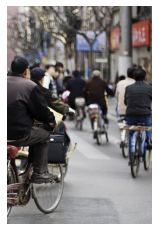

We show an example for which we obtained an high score result


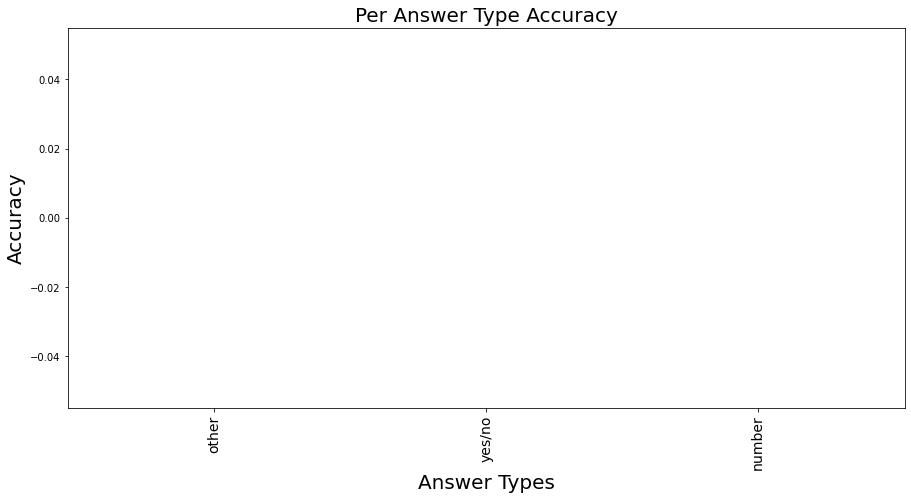

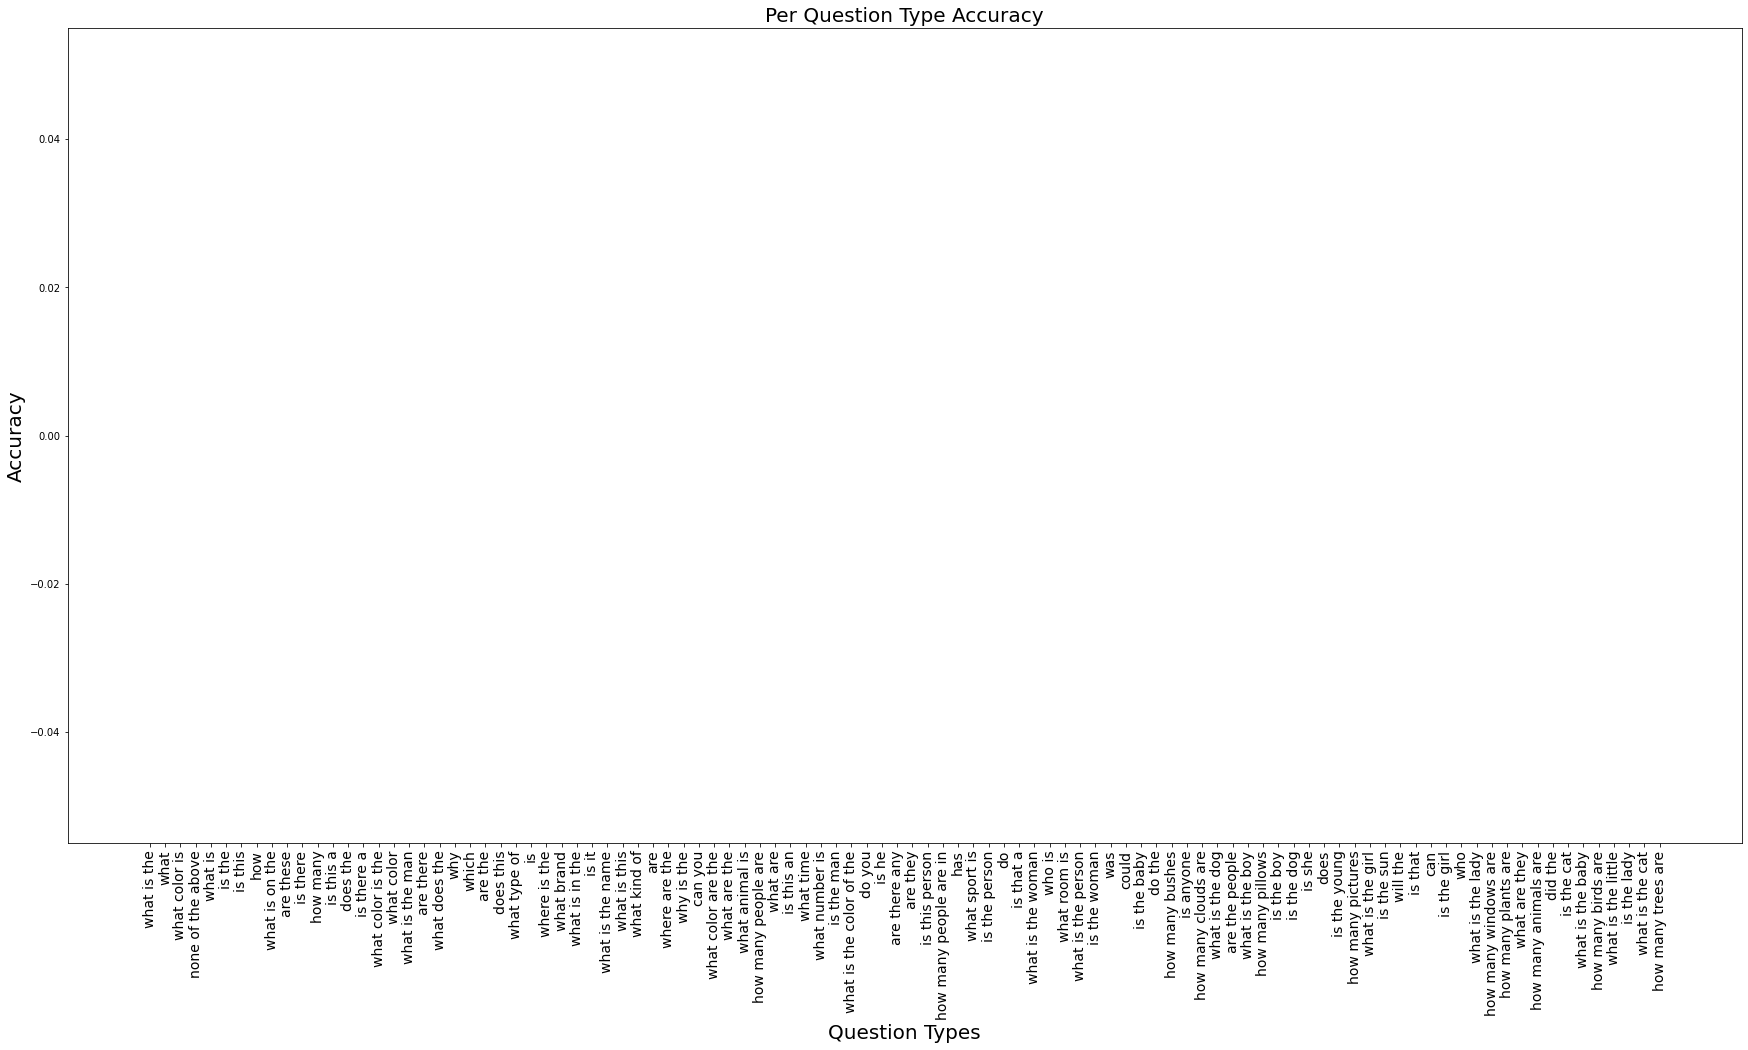

In [ ]:
if APPROACH == 'approach_2':
  # Evaluate the results over the test set
  evaluate_results(vqa_coco, vqa_abs, "/content/drive/MyDrive/DL_PROJECT_local/results/approach_2_glove300d_prefFalse.json", n=2)

We can see that the model's accuracy is 0% as one may expect.
Since this model has been trained with SGD, we obtain predictions that consist of MAX_ANSW_LEN random words.

Even using other optimizers, the accuracy is 0%, because the models always predict the [PAD] token, which leads to having empty answers.

Despite using pretrained LXMERT and pretrained GloVe embeddings, we are not able to train the model for a sufficiently high number of epochs because of the limited available resources. This results in the impossibility of seeing how the training progress across epochs, so that it is difficult to understand what should be possibly changed to improve the training.